In [58]:
import numpy as np
import pyodbc
import pandas as pd

In [88]:
sql_conn = pyodbc.connect('DRIVER={SQL Server};SERVER=51.222.82.146;DATABASE=STRATEGIO_OLAP_PROTISA;UID=Cesar_VS;PWD=Atenasmf626;Trusted_Connection=no')
query = "SELECT [CodigoDistribuidor],[CodigoFecha],SUM([VentaSinIgv]) AS Ventas FROM [STRATEGIO_OLAP_PROTISA].[pbix].[Ventas] WHERE [CodigoFecha]>='2020-01-01' and [CodigoFecha]<= '2020-12-31'  and [CodigoDistribuidor] not in ('20100239559.0','20100239559.1','20100239559.2','20100239559.3','20100239559.7','20100239559.9') GROUP BY [CodigoDistribuidor],[CodigoFecha]" 
df = pd.read_sql(query,sql_conn)

In [89]:
#df['CodigoFecha'] = pd.to_datetime(df.CodigoFecha,infer_datetime_format=True)

In [90]:
#fechas = pd.date_range(df.CodigoFecha.min(), df.CodigoFecha.max(),freq='D')

In [91]:
#data = pd.DataFrame()
#for i in df.CodigoDistribuidor.unique():
#    data = data.append(df[df.CodigoDistribuidor==i].set_index('CodigoFecha').reindex(fechas))
#    data['CodigoDistribuidor'] = data['CodigoDistribuidor'].fillna(i)
#    data['Ventas'] = data['Ventas'].fillna(0.0)

In [93]:
#data = data.reset_index()
#data.columns = ['CodigoFecha','CodigoDistribuidor','Ventas']

In [98]:
def transformar_data(data):
    df = data.copy()
    df['CodigoFecha'] = pd.to_datetime(df.CodigoFecha,infer_datetime_format=True)
    df['Mes'] = df['CodigoFecha'].dt.month
    distribuidor = df.groupby(['CodigoDistribuidor','Mes','CodigoFecha']).sum()
    distribuidor['Ventas_acumuladas'] = distribuidor.groupby(level=[0,1]).cumsum()
    distribuidor = distribuidor.reset_index()
    distribuidor = distribuidor[distribuidor['CodigoDistribuidor'].isin(distribuidor['CodigoDistribuidor'].value_counts()[distribuidor['CodigoDistribuidor'].value_counts() > 300].index)]
    for i in range(1,8):
        for j in ['Ventas','Ventas_acumuladas']:
            a = distribuidor.groupby(['CodigoDistribuidor','Mes','CodigoFecha'])[j].mean().groupby(level=[0,1]).shift(i).reset_index()
            distribuidor = pd.merge(distribuidor,a,on=['CodigoDistribuidor','Mes','CodigoFecha'],suffixes=('',f'_last_{i}'))
    distribuidor.fillna(0.00,inplace=True)
    distribuidor['Day'] = distribuidor.CodigoFecha.dt.day
    distribuidor['CodigoDistribuidor'] = distribuidor['CodigoDistribuidor'].astype('category')
    distribuidor['Mes'] = distribuidor['Mes'].astype('category')
    distribuidor['Day'] = distribuidor['Day'].astype('category')

    return distribuidor

In [104]:
test_df = transformar_data(df)

In [105]:
test_df.head(3)

CodigoDistribuidor Mes CodigoFecha      Ventas  Ventas_acumuladas  \
0             787878   1  2020-01-04    314.2544           314.2544   
1             787878   1  2020-01-06  26166.2452         26480.4996   
2             787878   1  2020-01-07  16151.7701         42632.2697   

   Ventas_last_1  Ventas_acumuladas_last_1  Ventas_last_2  \
0         0.0000                    0.0000         0.0000   
1       314.2544                  314.2544         0.0000   
2     26166.2452                26480.4996       314.2544   

   Ventas_acumuladas_last_2  Ventas_last_3  Ventas_acumuladas_last_3  \
0                    0.0000            0.0                       0.0   
1                    0.0000            0.0                       0.0   
2                  314.2544            0.0                       0.0   

   Ventas_last_4  Ventas_acumuladas_last_4  Ventas_last_5  \
0            0.0                       0.0            0.0   
1            0.0                       0.0            0.0   
2            0.0                       0.0            0.0   

   Ventas_acumuladas_last_5  Ventas_last_6  Ventas_acumuladas_last_6  \
0                       0.0            0.0                       0.0   
1                       0.0            0.0                       0.0   
2                       0.0            0.0                       0.0   

   Ventas_last_7  Ventas_acumuladas_last_7 Day  
0            0.0                       0.0   4  
1            0.0                       0.0   6  
2            0.0                       0.0   7

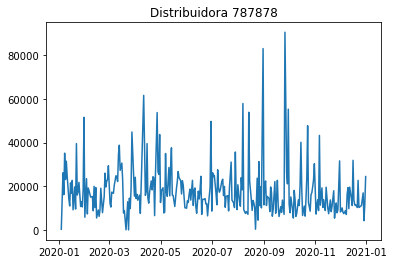

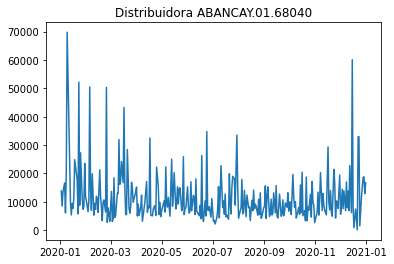

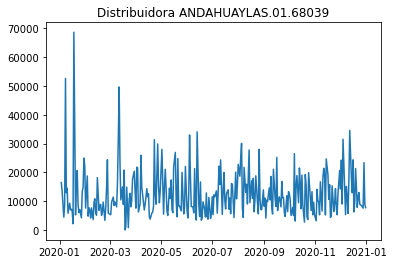

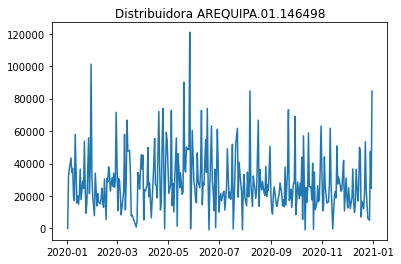

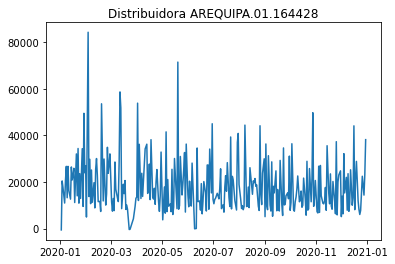

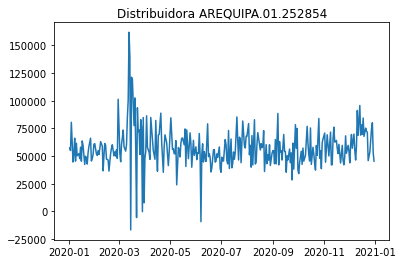

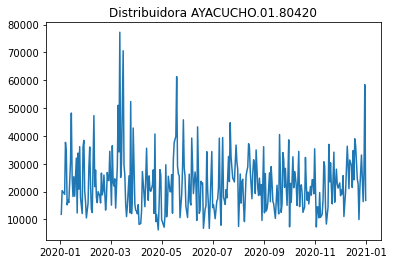

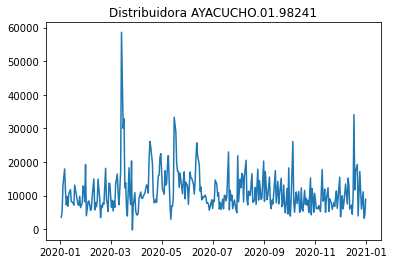

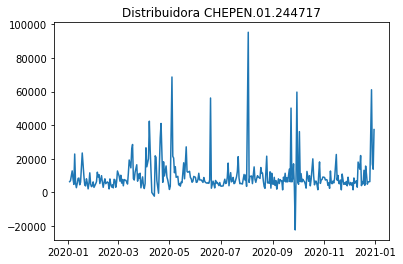

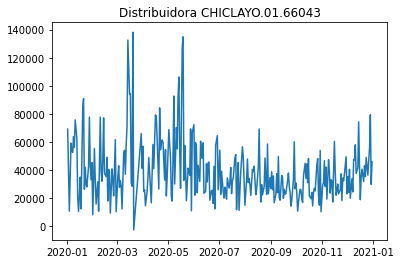

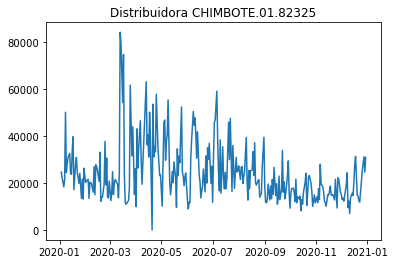

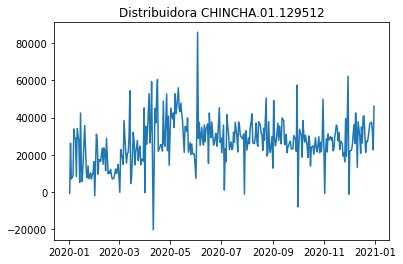

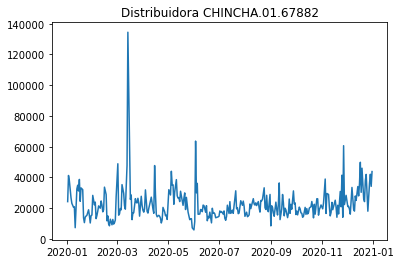

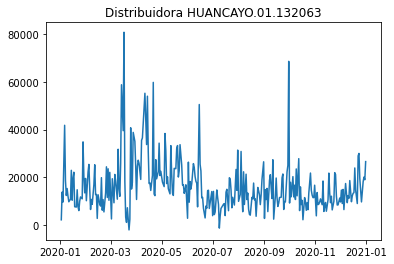

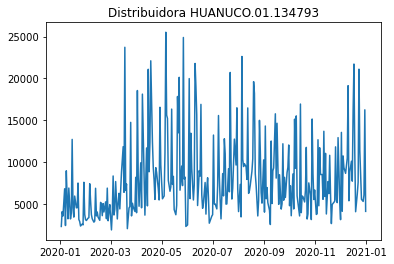

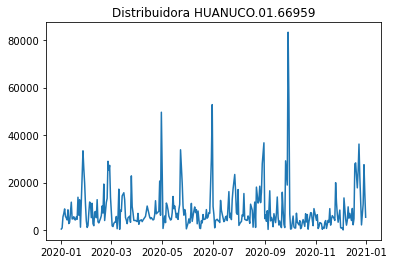

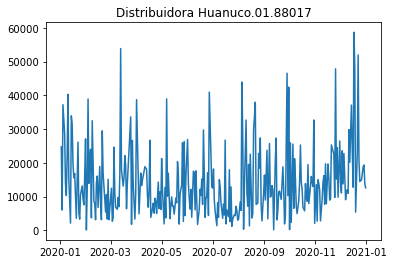

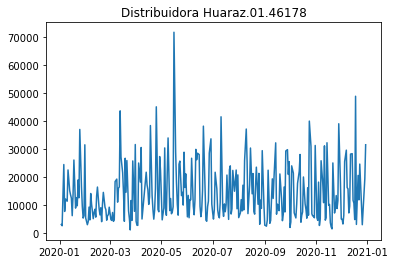

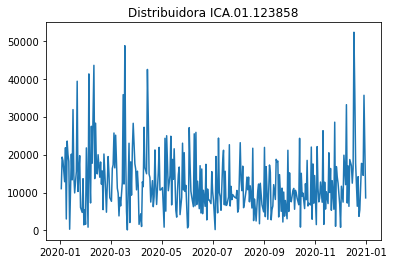

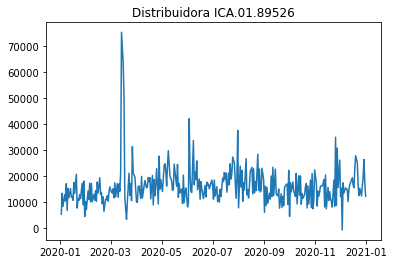

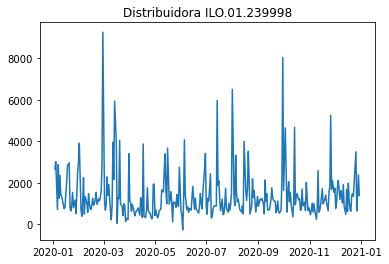

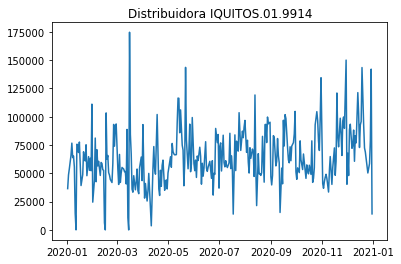

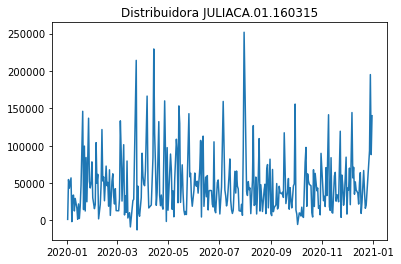

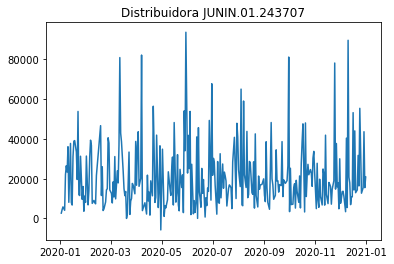

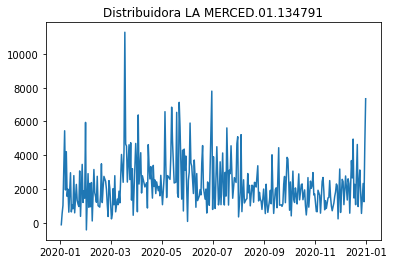

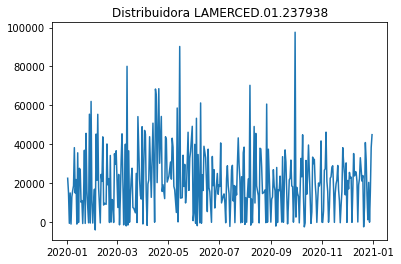

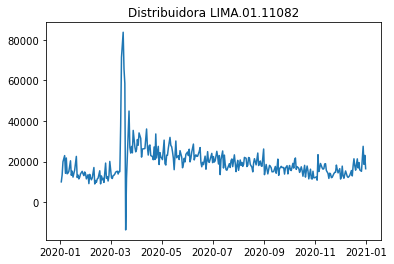

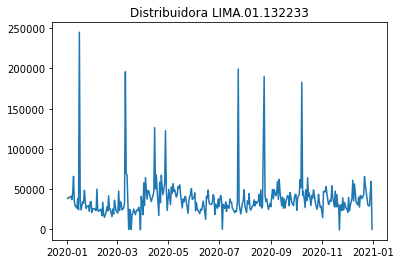

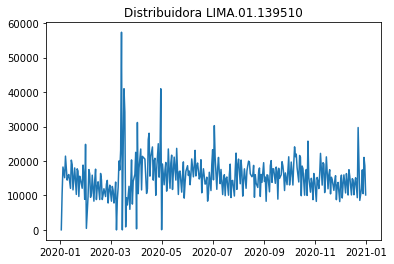

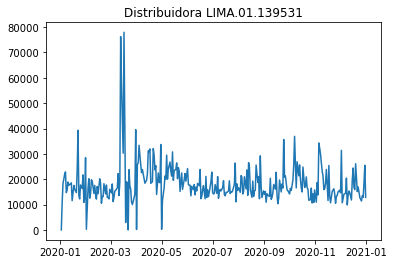

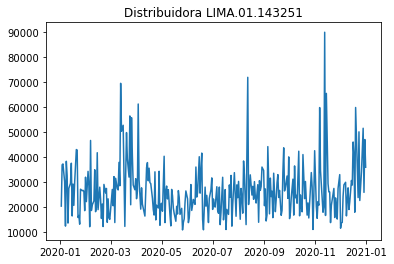

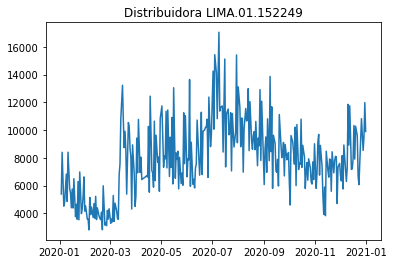

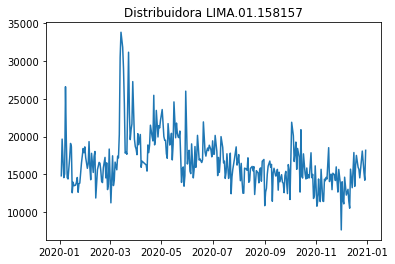

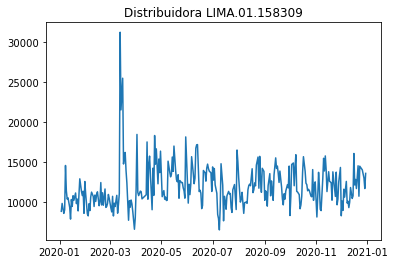

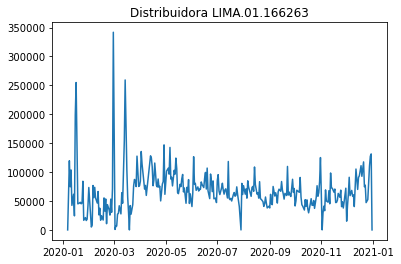

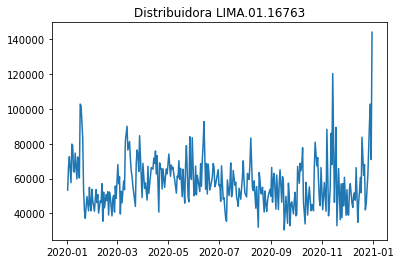

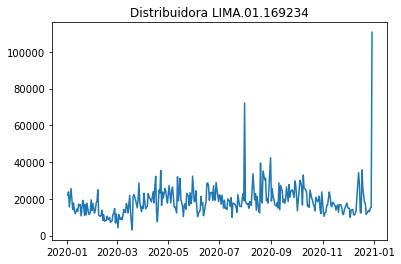

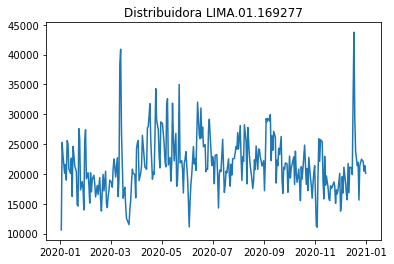

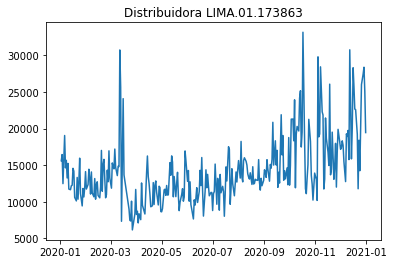

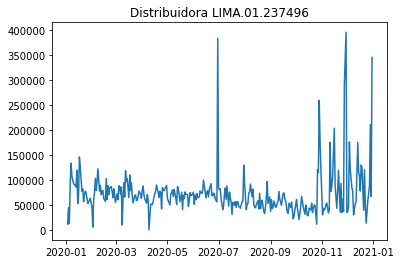

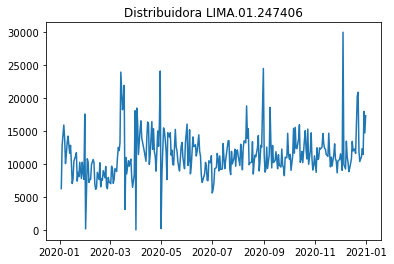

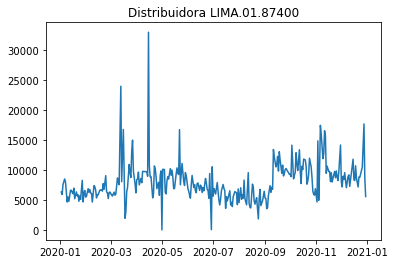

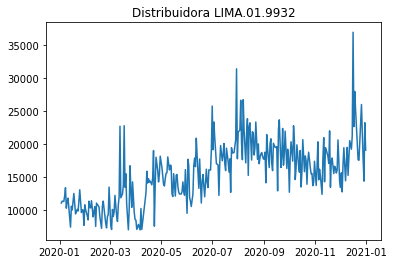

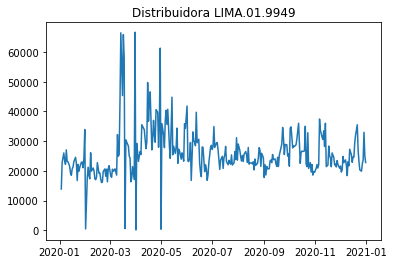

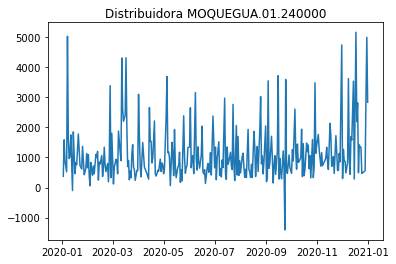

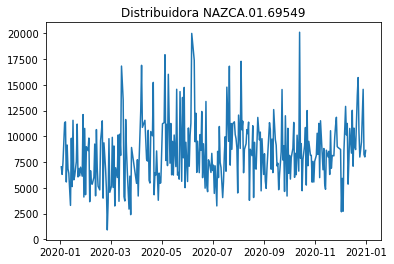

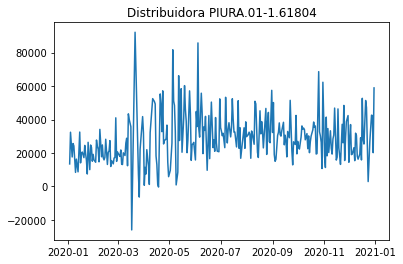

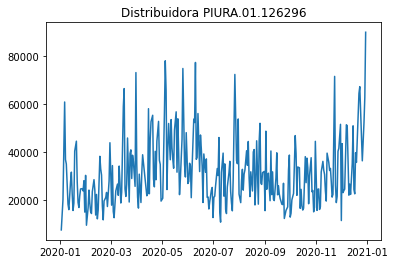

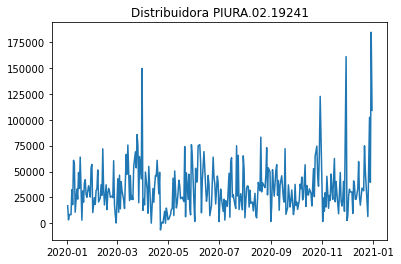

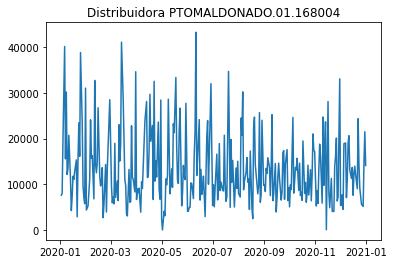

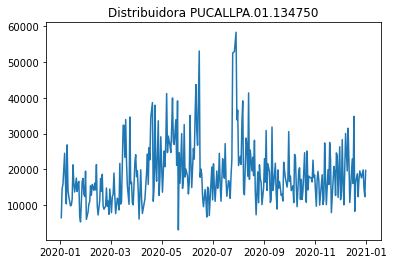

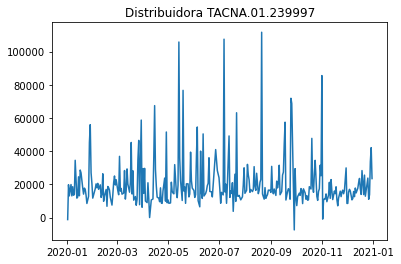

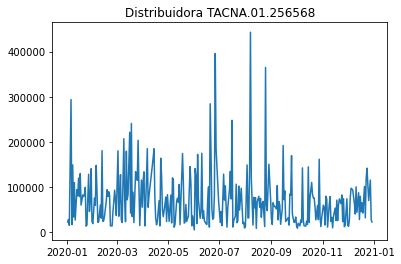

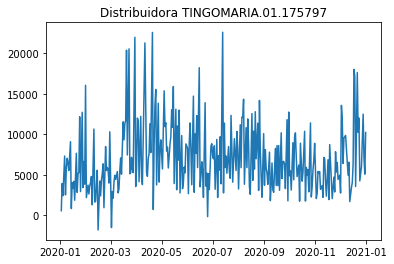

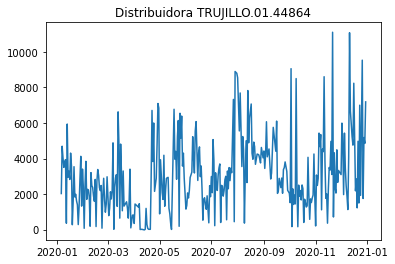

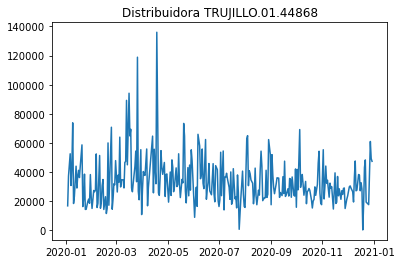

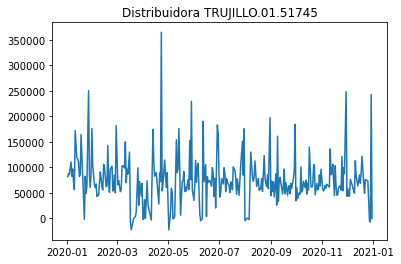

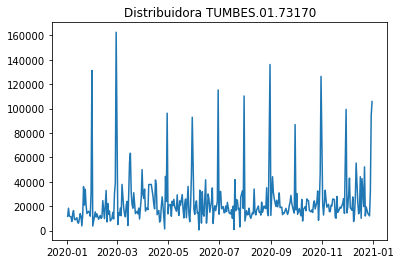

In [106]:
import matplotlib.pyplot as plt

dist_names = test_df.CodigoDistribuidor.unique()
for i in dist_names:
    plt.plot(test_df[test_df['CodigoDistribuidor']==i]['CodigoFecha'], test_df[test_df['CodigoDistribuidor']==i]['Ventas'])
    #plt.plot(test_df[test_df['CodigoDistribuidor']==i]['CodigoFecha'], test_df[test_df['CodigoDistribuidor']==i]['Ventas_acumuladas'])
    plt.title(f'Distribuidora {i}')
    plt.show()

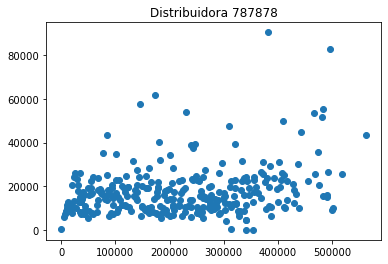

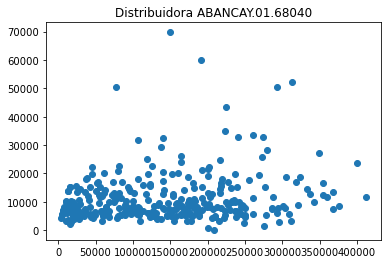

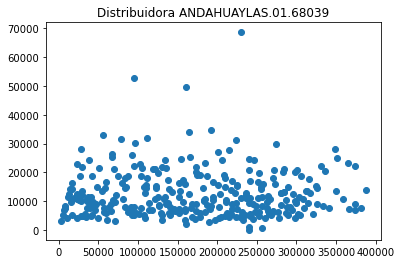

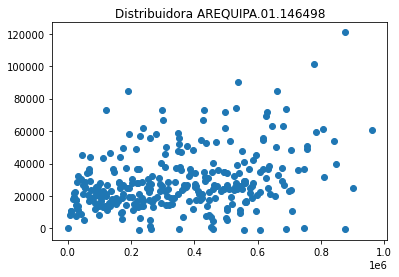

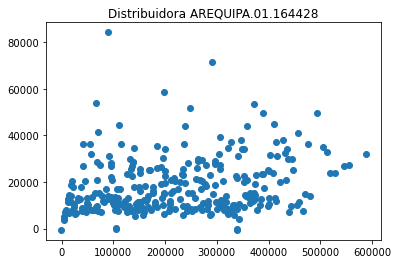

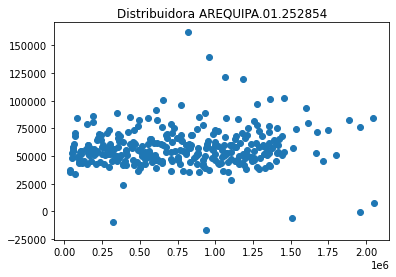

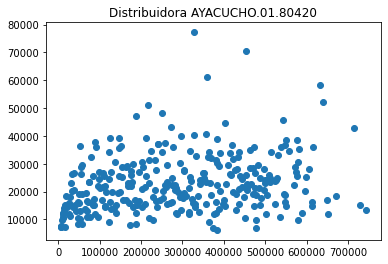

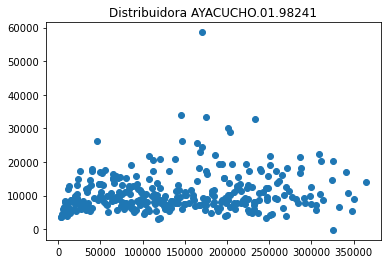

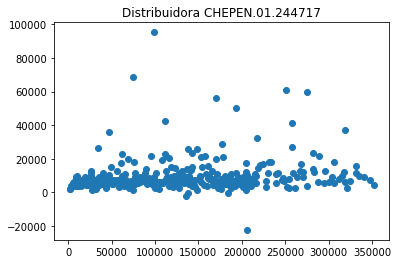

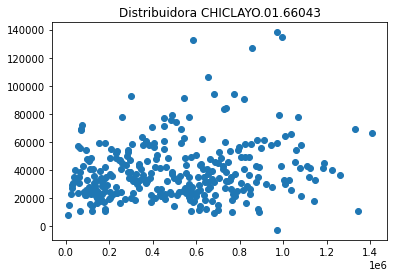

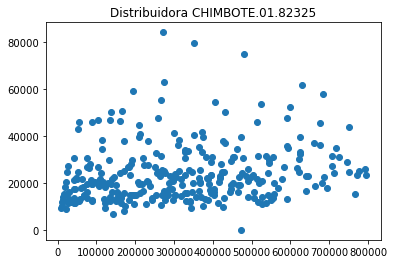

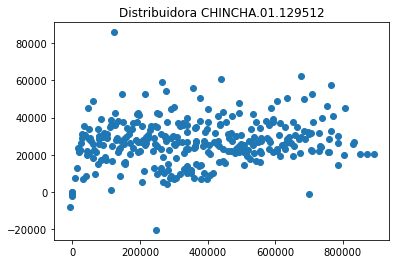

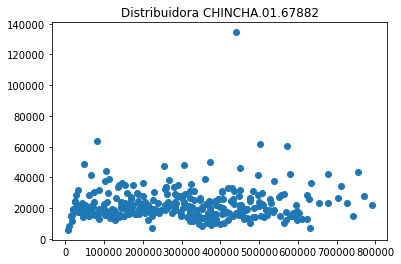

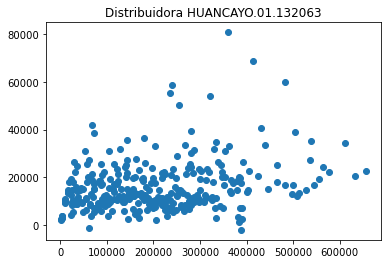

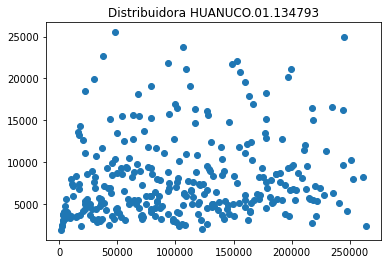

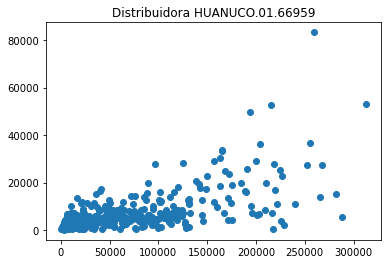

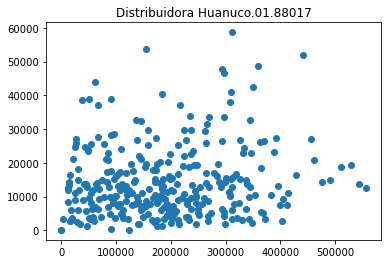

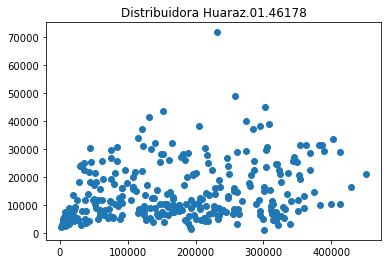

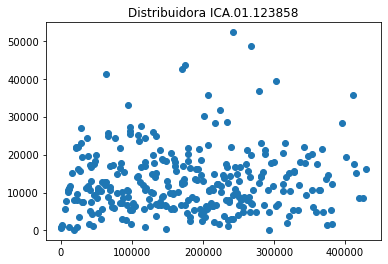

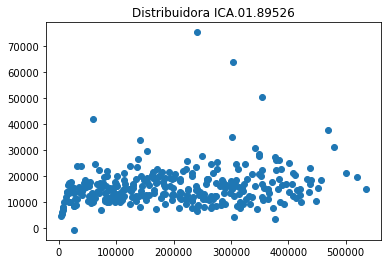

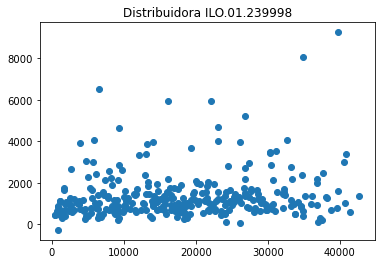

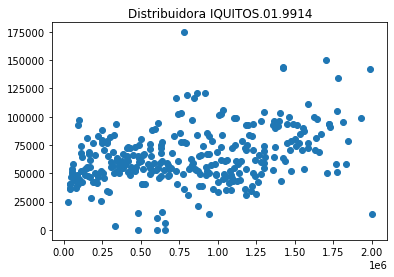

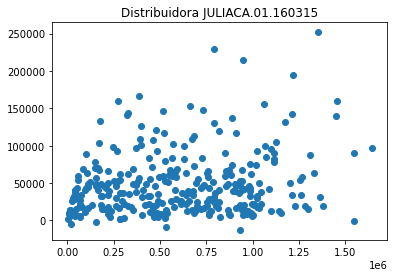

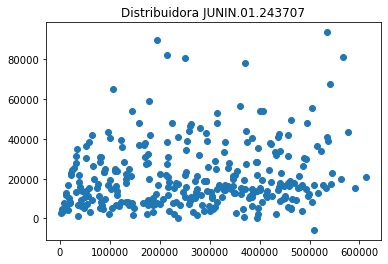

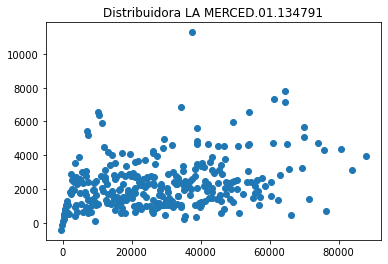

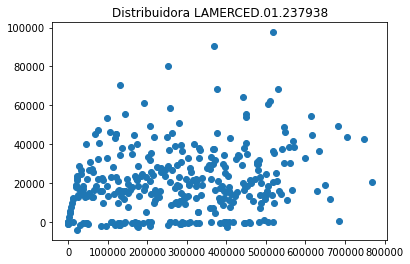

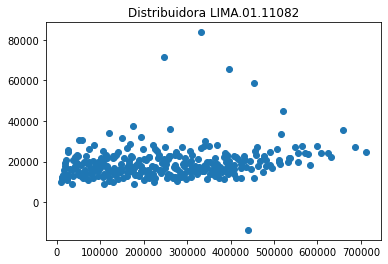

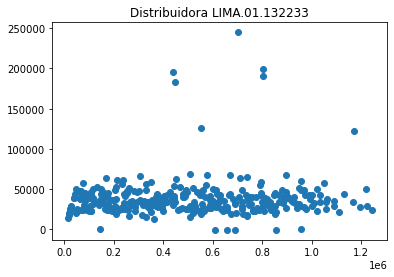

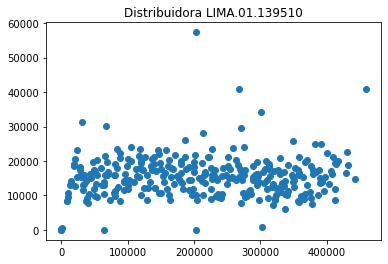

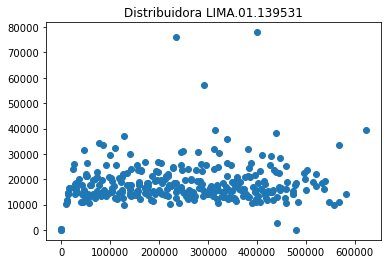

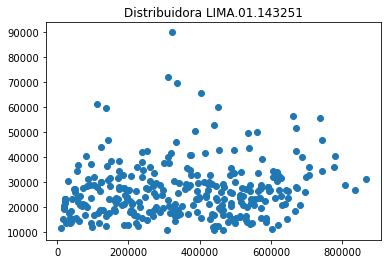

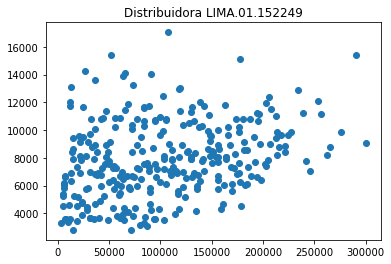

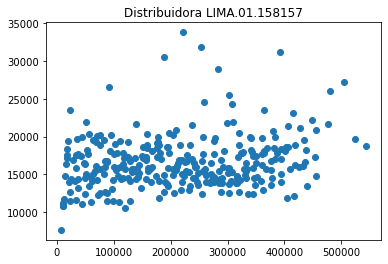

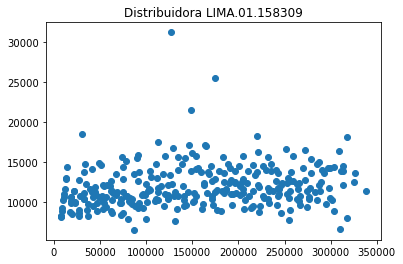

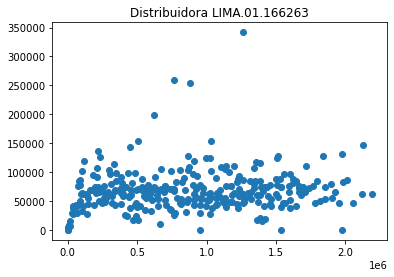

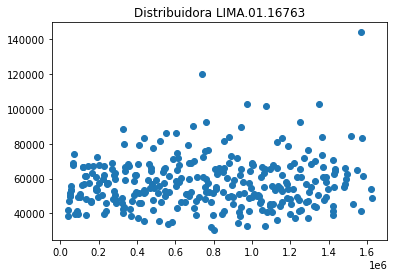

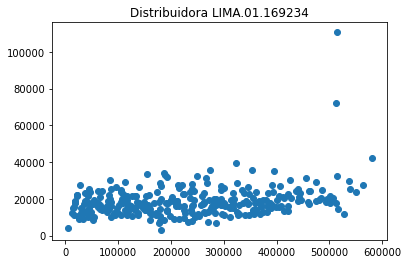

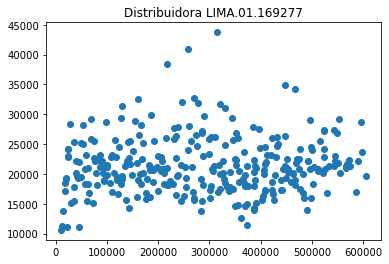

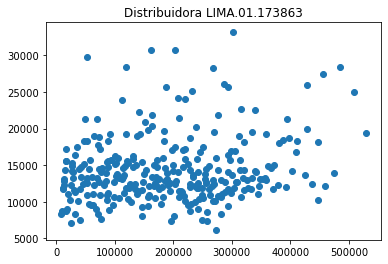

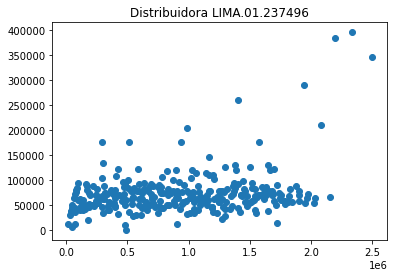

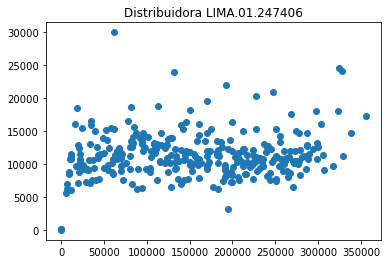

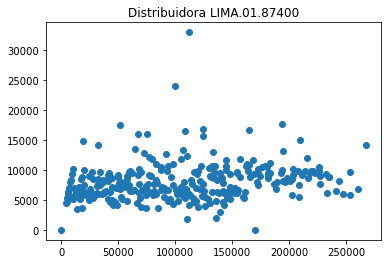

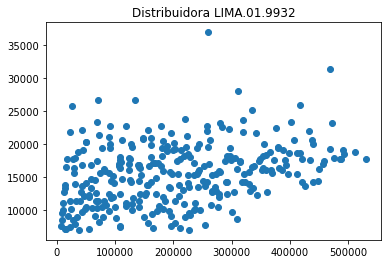

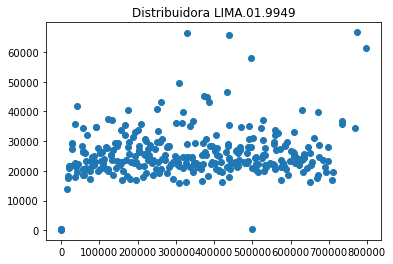

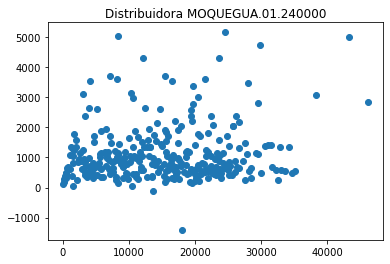

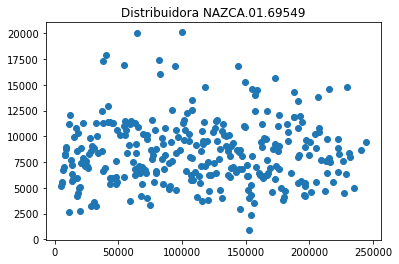

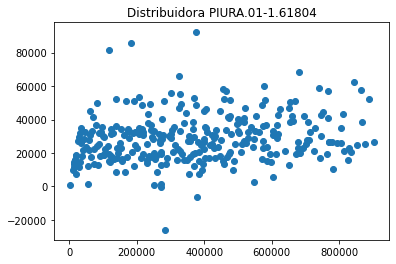

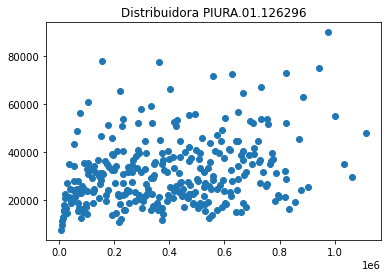

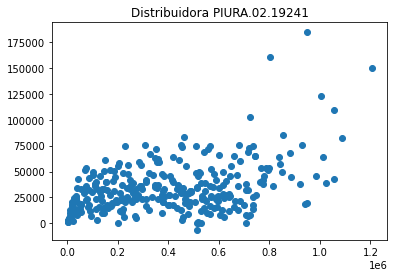

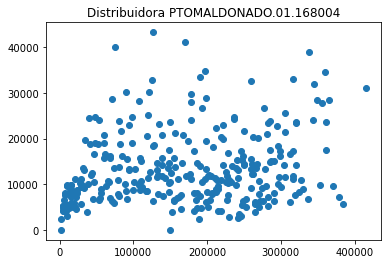

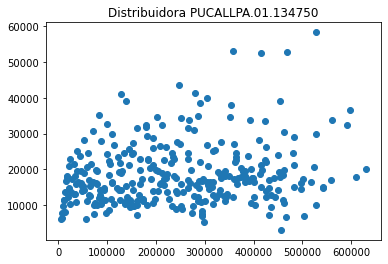

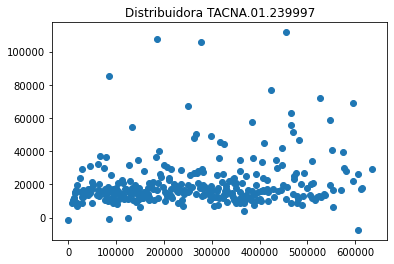

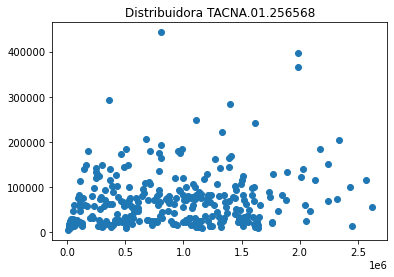

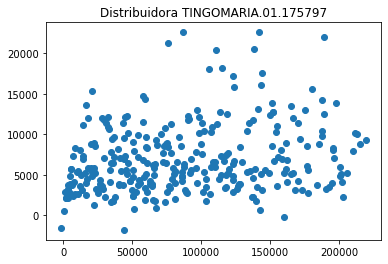

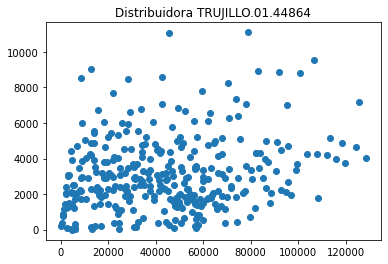

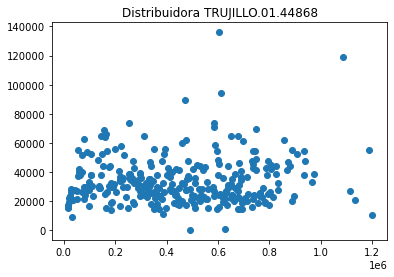

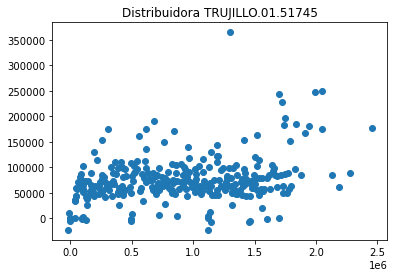

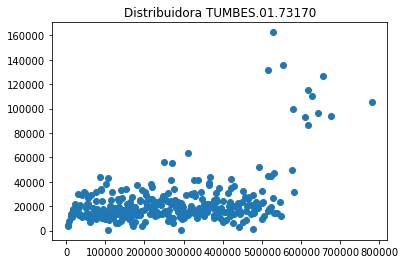

In [8]:
import matplotlib.pyplot as plt

dist_names = test_df.CodigoDistribuidor.unique()
for i in dist_names:
    plt.scatter(test_df[test_df['CodigoDistribuidor']==i]['Ventas_acumuladas'], test_df[test_df['CodigoDistribuidor']==i]['Ventas'])
    plt.title(f'Distribuidora {i}')
    plt.show()

In [9]:
test_df.to_csv('data.csv')

In [10]:
test_df.isnull().sum()

CodigoDistribuidor          0
Mes                         0
CodigoFecha                 0
Ventas                      0
Ventas_acumuladas           0
Ventas_last_1               0
Ventas_acumuladas_last_1    0
Ventas_last_2               0
Ventas_acumuladas_last_2    0
Ventas_last_3               0
Ventas_acumuladas_last_3    0
Ventas_last_4               0
Ventas_acumuladas_last_4    0
Ventas_last_5               0
Ventas_acumuladas_last_5    0
Ventas_last_6               0
Ventas_acumuladas_last_6    0
Ventas_last_7               0
Ventas_acumuladas_last_7    0
Day                         0
dtype: int64

# Armamos el modelo ElasticNet

In [11]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MaxAbsScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

In [12]:
test_df.columns

Index(['CodigoDistribuidor', 'Mes', 'CodigoFecha', 'Ventas',
       'Ventas_acumuladas', 'Ventas_last_1', 'Ventas_acumuladas_last_1',
       'Ventas_last_2', 'Ventas_acumuladas_last_2', 'Ventas_last_3',
       'Ventas_acumuladas_last_3', 'Ventas_last_4', 'Ventas_acumuladas_last_4',
       'Ventas_last_5', 'Ventas_acumuladas_last_5', 'Ventas_last_6',
       'Ventas_acumuladas_last_6', 'Ventas_last_7', 'Ventas_acumuladas_last_7',
       'Day'],
      dtype='object')

In [13]:
X = test_df.drop(['Ventas','Ventas_acumuladas','CodigoFecha'],axis=1)
y = test_df[['Ventas_acumuladas']]
cat_cols = ['CodigoDistribuidor','Mes','Day']
num_cols = ['Ventas_last_1','Ventas_last_2','Ventas_last_3','Ventas_last_4','Ventas_last_5','Ventas_last_6','Ventas_last_7','Ventas_acumuladas_last_1','Ventas_acumuladas_last_2','Ventas_acumuladas_last_3','Ventas_acumuladas_last_4','Ventas_acumuladas_last_5','Ventas_acumuladas_last_6','Ventas_acumuladas_last_7']

In [14]:
cat_encoder = OneHotEncoder(handle_unknown='ignore')
num_pipe = MaxAbsScaler()
preprocessing = ColumnTransformer([('cat',cat_encoder,cat_cols),('num',num_pipe,num_cols)])
model = ElasticNet()
steps = [('preprocess', preprocessing), ('elasticnet', model)]
pipeline = Pipeline(steps)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=126)

In [15]:
parameters = {'elasticnet__l1_ratio':np.linspace(0, 1, 30)}
gm_cv = GridSearchCV(pipeline, param_grid=parameters, cv=5)

In [16]:
gm_cv.fit(X_train,y_train)

C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 492752434887570.9, tolerance: 114373565757.31505
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 507067567322804.25, tolerance: 114788213737.5327
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 510714634843924.0, tolerance: 115979679302.1299
  model = cd_fast.sparse_enet_coordinate_descent(
C:\Users\DELL\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:513

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['CodigoDistribuidor',
                                                                          'Mes',
                                                                          'Day']),
                                                                        ('num',
                                                                         MaxAbsScaler(),
                                                                         ['Ventas_last_1',
                                                                          'Ventas_last_2',
                                                                          'Ventas_last_3',
                                

In [17]:
r2 = gm_cv.score(X_test, y_test)
print('R^2:',r2)

R^2: 0.9974985701104602


In [18]:
y_pred = gm_cv.predict(X_test)

In [19]:
from sklearn.metrics import mean_squared_error

print('RSME:',np.sqrt(mean_squared_error(y_test,y_pred)))

RSME: 16203.708873634638


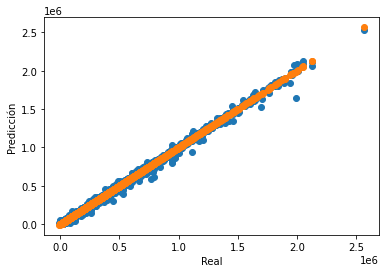

In [20]:
_ = plt.scatter(y_test,y_pred)
_ = plt.scatter(y_test,y_test)
_ = plt.xlabel('Real')
_ = plt.ylabel('Predicción')
plt.show()

In [21]:
test_df['prediccion'] = gm_cv.predict(X)

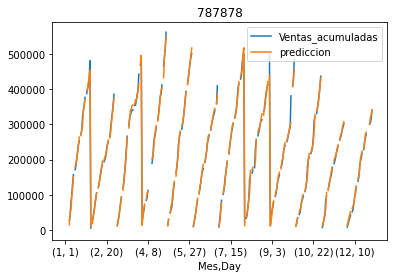

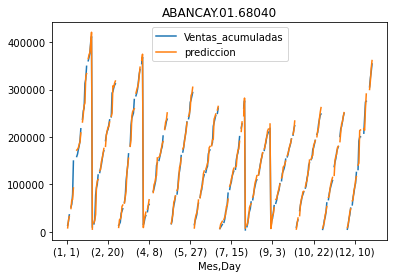

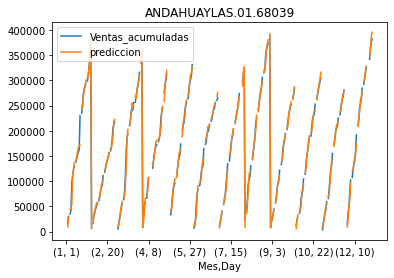

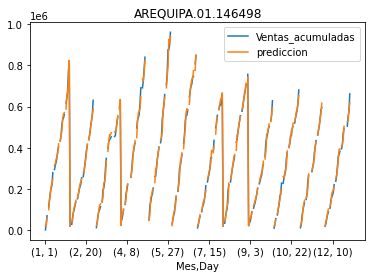

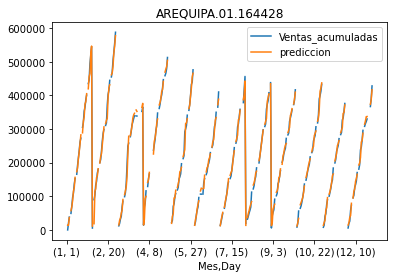

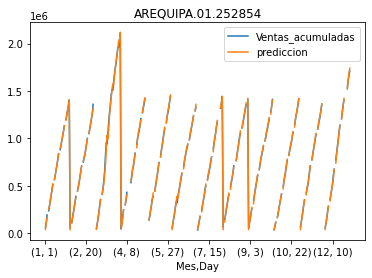

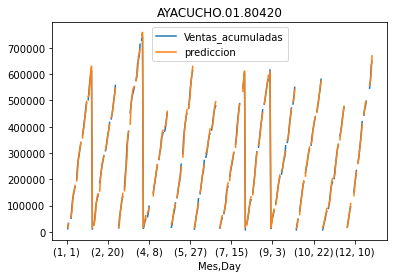

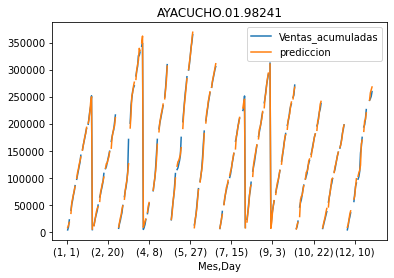

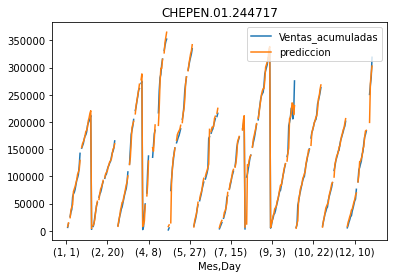

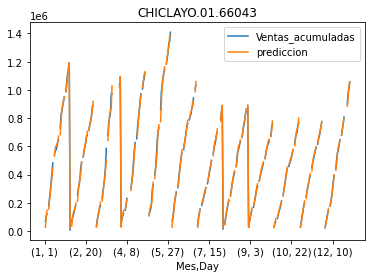

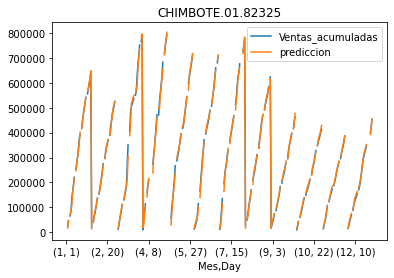

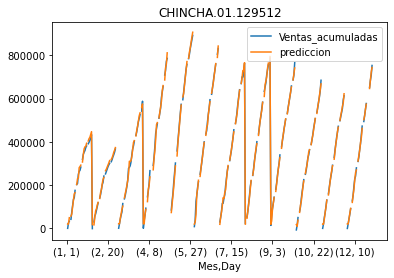

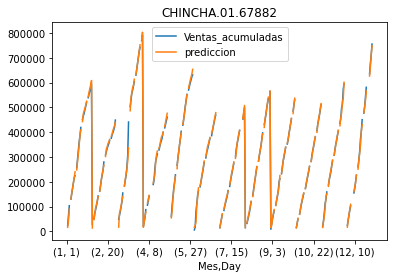

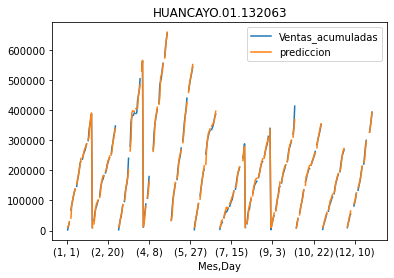

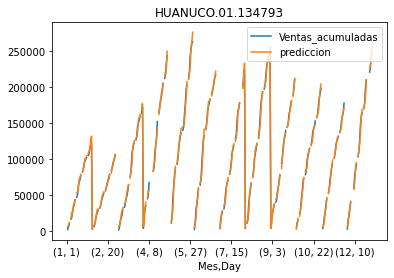

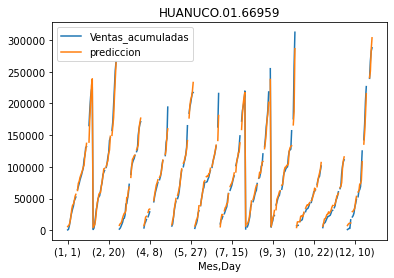

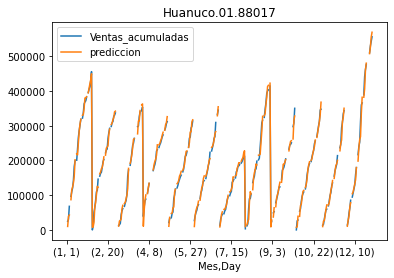

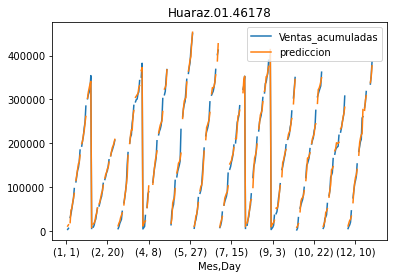

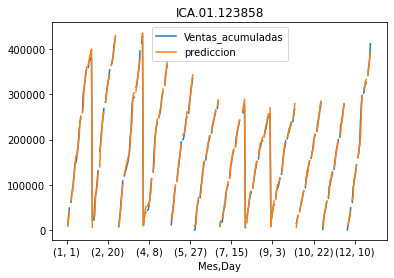

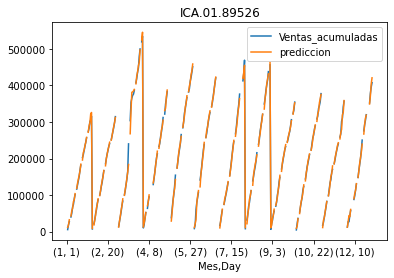

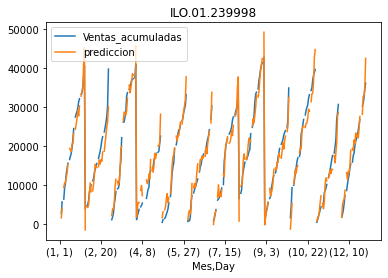

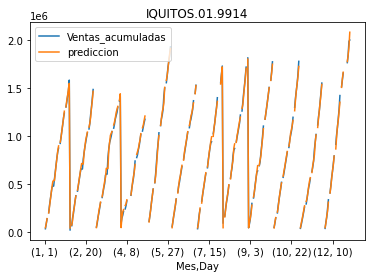

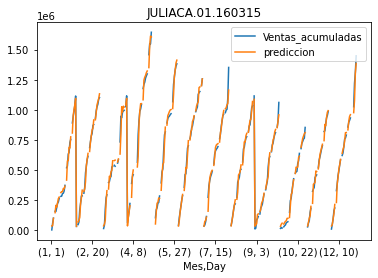

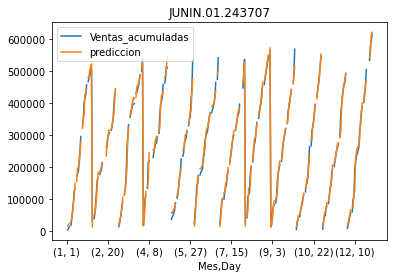

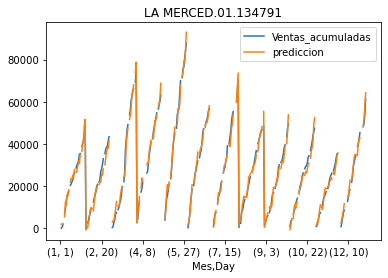

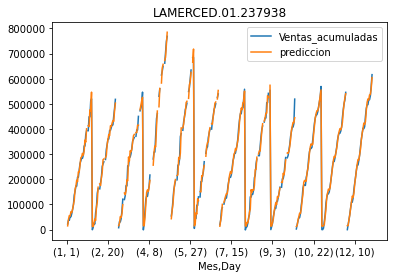

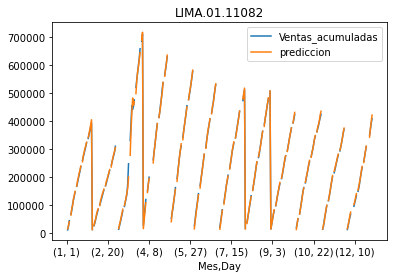

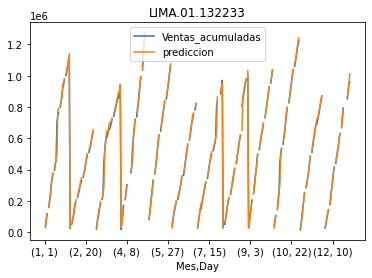

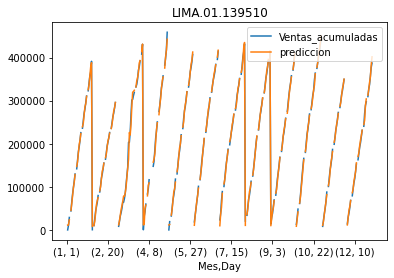

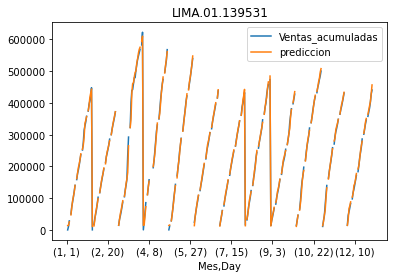

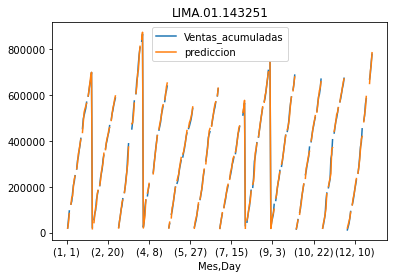

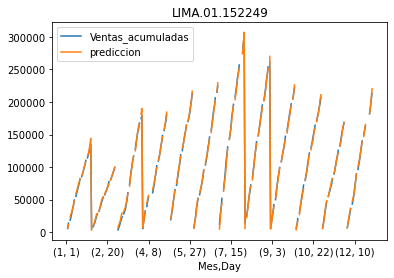

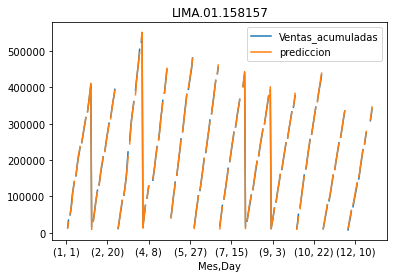

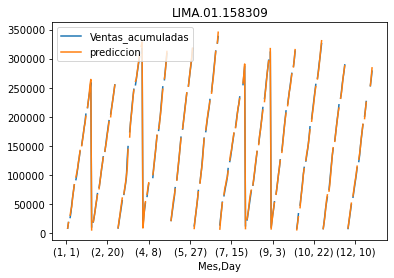

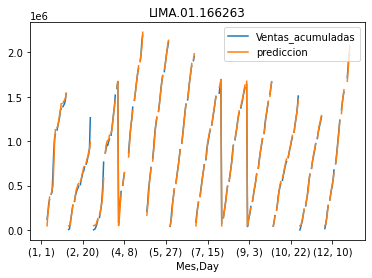

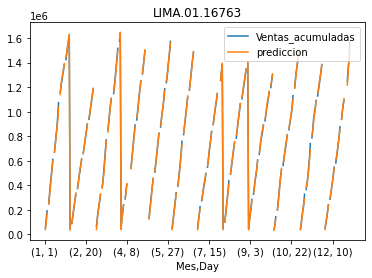

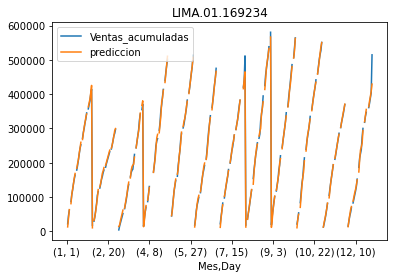

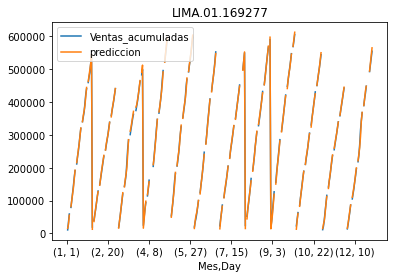

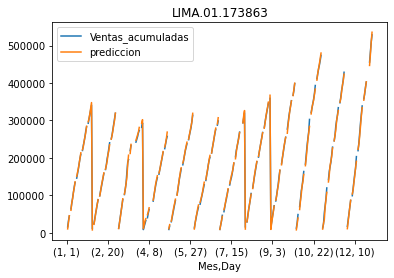

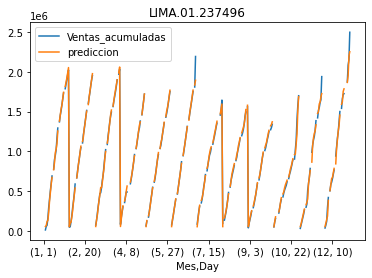

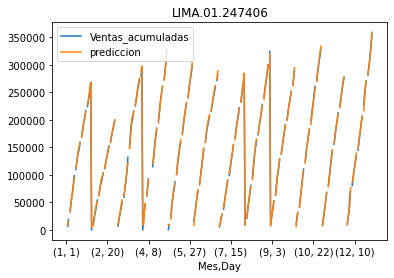

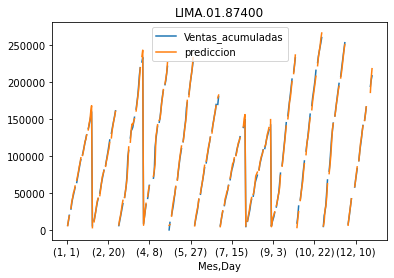

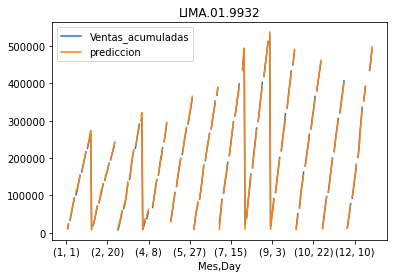

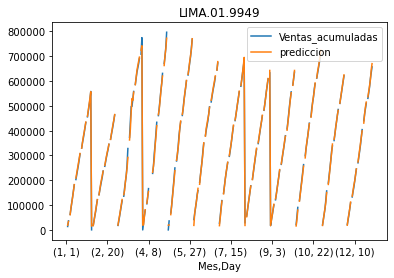

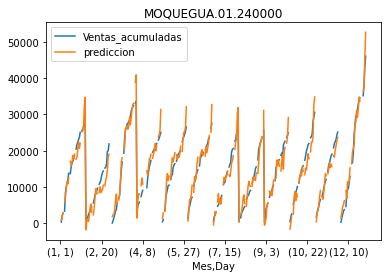

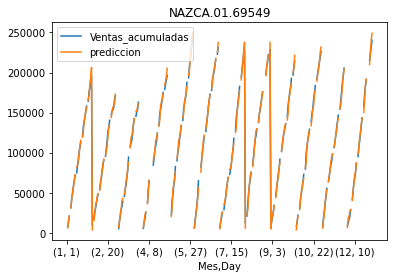

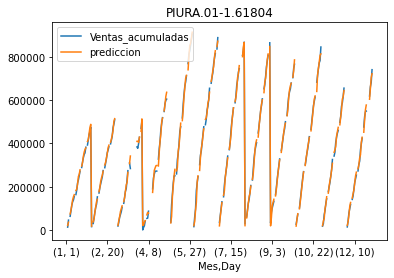

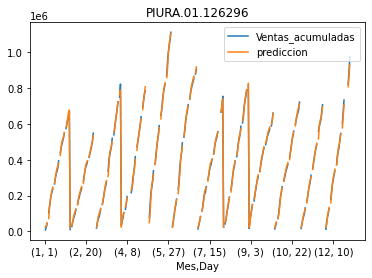

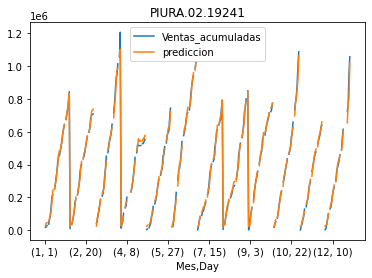

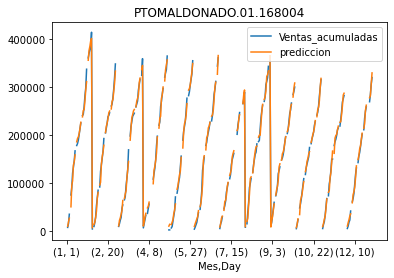

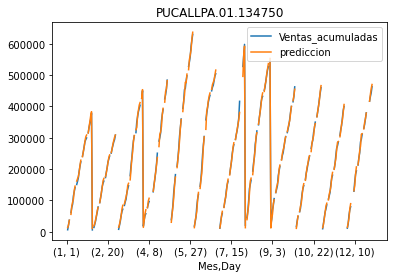

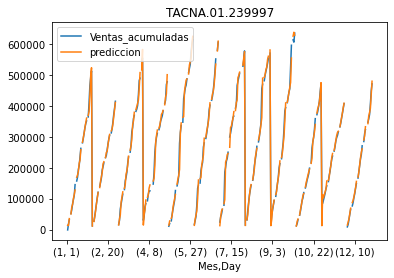

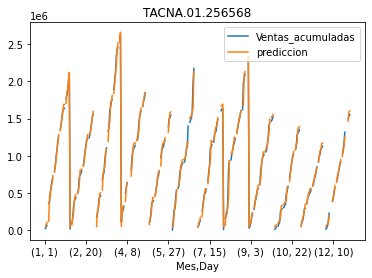

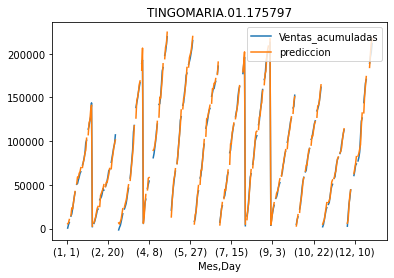

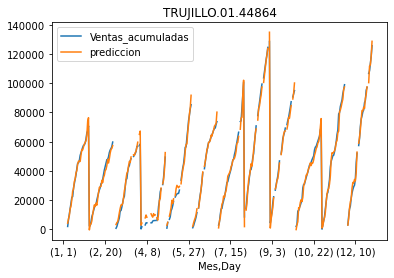

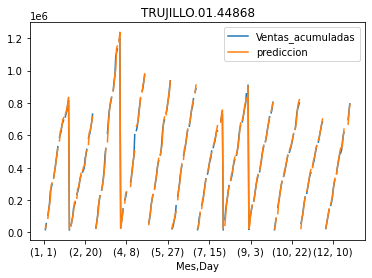

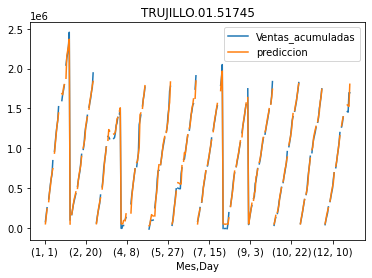

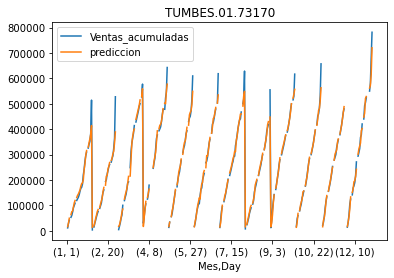

In [22]:
for i in test_df.CodigoDistribuidor.unique():
    _ = test_df[test_df.CodigoDistribuidor == i].groupby(['Mes','Day'])[['Ventas_acumuladas','prediccion']].mean().plot()
    _ = plt.title(i)
    plt.show()

In [23]:
print(gm_cv.best_params_)
results = pd.DataFrame(gm_cv.cv_results_)
results

{'elasticnet__l1_ratio': 1.0}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        4.424218  1.316221e-01         0.009374        0.007654   
1        0.058209  1.121327e-02         0.007114        0.006291   
2        0.052719  8.005036e-03         0.006249        0.007654   
3        0.054323  9.334301e-03         0.005324        0.006682   
4        0.049988  6.248665e-03         0.012705        0.006365   
5        0.053112  7.652826e-03         0.009373        0.007653   
6        0.049989  6.257373e-03         0.006247        0.007652   
7        0.046864  6.289914e-07         0.009373        0.007653   
8        0.047077  4.247213e-04         0.006248        0.007652   
9        0.049988  6.248760e-03         0.006249        0.007653   
10       0.056237  7.652650e-03         0.009373        0.007653   
11       0.050206  6.684351e-03         0.009780        0.008020   
12       0.052211  1.141233e-02         0.011544        0.003894   
13       0.055566  6.228049e-03         0.003398        0.004265   
14       0.049988  6.248784e-03         0.009373        0.007653   
15       0.054304  6.665469e-03         0.009104        0.005319   
16       0.056151  7.965438e-03         0.011634        0.003434   
17       0.051136  7.519333e-03         0.004588        0.003764   
18       0.056658  1.143671e-02         0.006316        0.005898   
19       0.063094  8.953679e-03         0.004877        0.006351   
20       0.053109  7.655943e-03         0.006253        0.007658   
21       0.059361  6.249189e-03         0.006461        0.007921   
22       0.065628  1.533615e-02         0.004725        0.006269   
23       0.060372  2.595801e-03         0.004720        0.006266   
24       0.071964  6.946246e-03         0.004787        0.005863   
25       0.067681  1.544846e-02         0.009373        0.007653   
26       0.081710  1.775551e-02         0.009042        0.005948   
27       0.078608  8.620975e-03         0.012632        0.003530   
28       0.098233  9.142175e-03         0.006515        0.006000   
29       4.213377  1.452691e-01         0.006515        0.006000   

   param_elasticnet__l1_ratio                                          params  \
0                         0.0                   {'elasticnet__l1_ratio': 0.0}   
1                    0.034483  {'elasticnet__l1_ratio': 0.034482758620689655}   
2                    0.068966   {'elasticnet__l1_ratio': 0.06896551724137931}   
3                    0.103448   {'elasticnet__l1_ratio': 0.10344827586206896}   
4                    0.137931   {'elasticnet__l1_ratio': 0.13793103448275862}   
5                    0.172414    {'elasticnet__l1_ratio': 0.1724137931034483}   
6                    0.206897   {'elasticnet__l1_ratio': 0.20689655172413793}   
7                    0.241379   {'elasticnet__l1_ratio': 0.24137931034482757}   
8                    0.275862   {'elasticnet__l1_ratio': 0.27586206896551724}   
9                    0.310345    {'elasticnet__l1_ratio': 0.3103448275862069}   
10                   0.344828    {'elasticnet__l1_ratio': 0.3448275862068966}   
11                    0.37931    {'elasticnet__l1_ratio': 0.3793103448275862}   
12                   0.413793   {'elasticnet__l1_ratio': 0.41379310344827586}   
13                   0.448276    {'elasticnet__l1_ratio': 0.4482758620689655}   
14                   0.482759   {'elasticnet__l1_ratio': 0.48275862068965514}   
15                   0.517241    {'elasticnet__l1_ratio': 0.5172413793103449}   
16                   0.551724    {'elasticnet__l1_ratio': 0.5517241379310345}   
17                   0.586207    {'elasticnet__l1_ratio': 0.5862068965517241}   
18                    0.62069    {'elasticnet__l1_ratio': 0.6206896551724138}   
19                   0.655172    {'elasticnet__l1_ratio': 0.6551724137931034}   
20                   0.689655    {'elasticnet__l1_ratio': 0.6896551724137931}   
21                   0.724138    {'elasticnet__l1_ratio': 0.7241379310344828}   
22                   0.758621   

# Probamos como se desenvuelve el modelo en el año 2021

In [24]:
query = "SELECT [CodigoDistribuidor],[CodigoFecha],SUM([VentaSinIgv]) AS Ventas FROM [STRATEGIO_OLAP_PROTISA].[pbix].[Ventas] WHERE [CodigoFecha]>='2021-01-01' and [CodigoFecha]<= getdate()  and [CodigoDistribuidor] not in ('20100239559.0','20100239559.1','20100239559.2','20100239559.3','20100239559.7','20100239559.9') GROUP BY [CodigoDistribuidor],[CodigoFecha]" 
df_2 = pd.read_sql(query,sql_conn)

In [25]:
def transformar_data_2(data):
    df = data.copy()
    df['CodigoFecha'] = pd.to_datetime(df.CodigoFecha,infer_datetime_format=True)
    df['Mes'] = df['CodigoFecha'].dt.month
    distribuidor = df.groupby(['CodigoDistribuidor','Mes','CodigoFecha']).sum()
    distribuidor['Ventas_acumuladas'] = distribuidor.groupby(level=[0,1]).cumsum()
    distribuidor = distribuidor.reset_index()
    distribuidor = distribuidor[distribuidor['CodigoDistribuidor'].isin(distribuidor['CodigoDistribuidor'].value_counts()[distribuidor['CodigoDistribuidor'].value_counts() > 70].index)]
    for i in range(1,8):
        for j in ['Ventas','Ventas_acumuladas']:
            a = distribuidor.groupby(['CodigoDistribuidor','Mes','CodigoFecha'])[j].mean().groupby(level=[0,1]).shift(i).reset_index()
            distribuidor = pd.merge(distribuidor,a,on=['CodigoDistribuidor','Mes','CodigoFecha'],suffixes=('',f'_last_{i}'))
    distribuidor.fillna(0.00,inplace=True)
    distribuidor['Day'] = distribuidor.CodigoFecha.dt.day
    distribuidor['CodigoDistribuidor'] = distribuidor['CodigoDistribuidor'].astype('category')
    distribuidor['Mes'] = distribuidor['Mes'].astype('category')
    distribuidor['Day'] = distribuidor['Day'].astype('category')

    return distribuidor


In [26]:
test_data_2021 = transformar_data_2(df_2)

In [27]:
test_data_2021.columns

Index(['CodigoDistribuidor', 'Mes', 'CodigoFecha', 'Ventas',
       'Ventas_acumuladas', 'Ventas_last_1', 'Ventas_acumuladas_last_1',
       'Ventas_last_2', 'Ventas_acumuladas_last_2', 'Ventas_last_3',
       'Ventas_acumuladas_last_3', 'Ventas_last_4', 'Ventas_acumuladas_last_4',
       'Ventas_last_5', 'Ventas_acumuladas_last_5', 'Ventas_last_6',
       'Ventas_acumuladas_last_6', 'Ventas_last_7', 'Ventas_acumuladas_last_7',
       'Day'],
      dtype='object')

In [28]:
X_2021 = test_data_2021.drop(['Ventas','Ventas_acumuladas','CodigoFecha'],axis=1)
test_data_2021['prediccion'] = gm_cv.predict(X_2021)

In [29]:
print(X_2021.columns)

Index(['CodigoDistribuidor', 'Mes', 'Ventas_last_1',
       'Ventas_acumuladas_last_1', 'Ventas_last_2', 'Ventas_acumuladas_last_2',
       'Ventas_last_3', 'Ventas_acumuladas_last_3', 'Ventas_last_4',
       'Ventas_acumuladas_last_4', 'Ventas_last_5', 'Ventas_acumuladas_last_5',
       'Ventas_last_6', 'Ventas_acumuladas_last_6', 'Ventas_last_7',
       'Ventas_acumuladas_last_7', 'Day'],
      dtype='object')


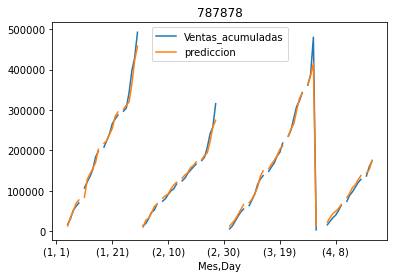

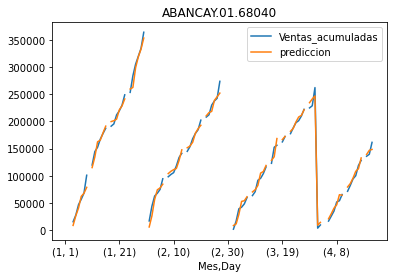

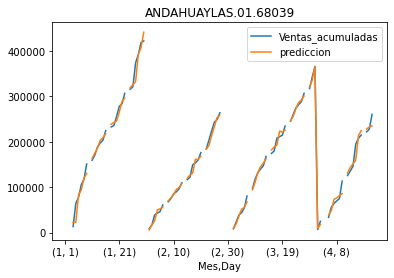

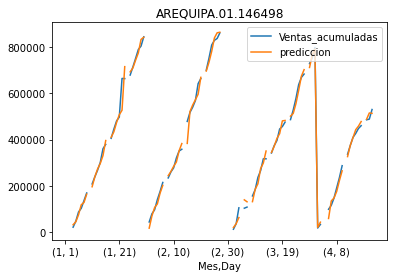

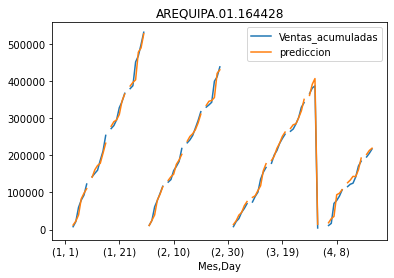

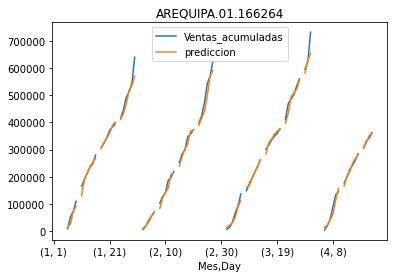

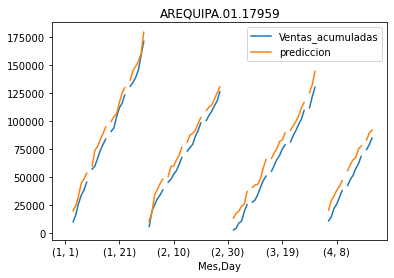

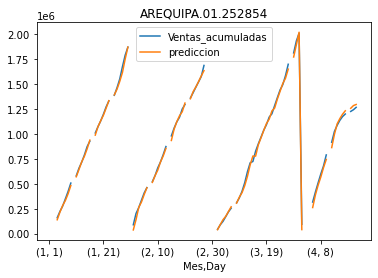

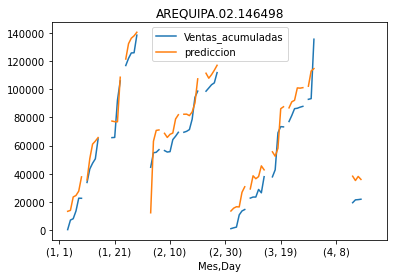

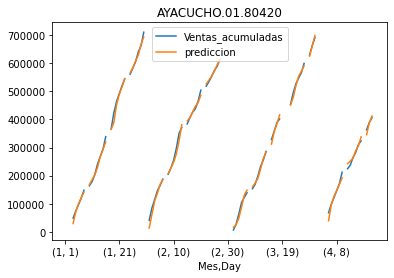

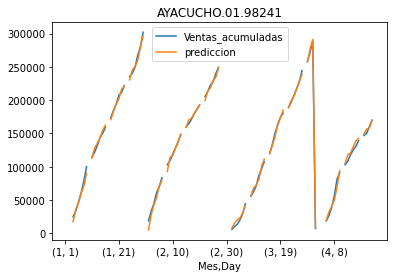

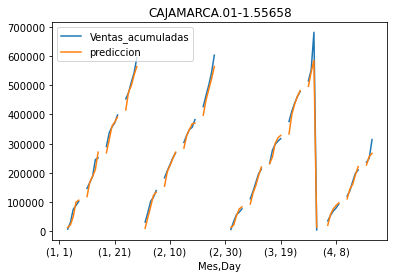

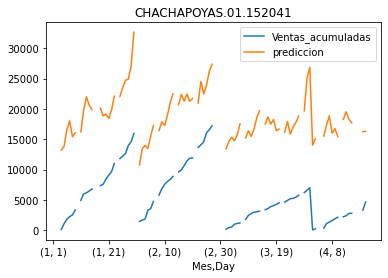

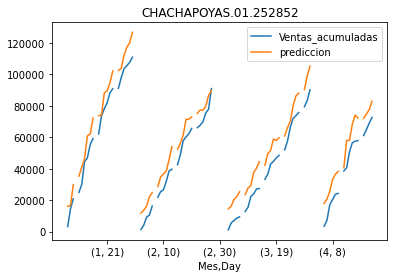

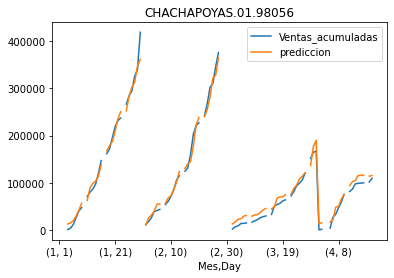

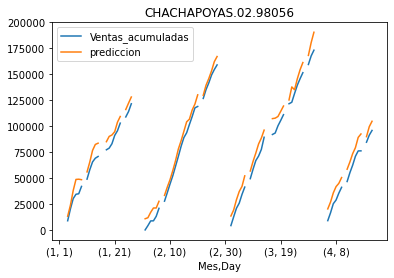

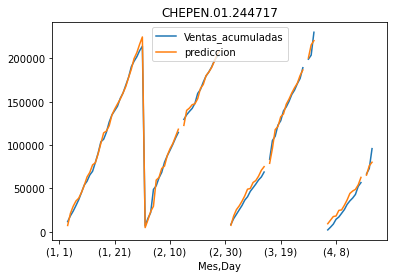

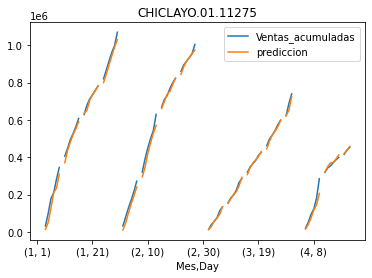

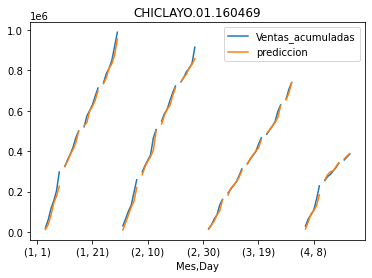

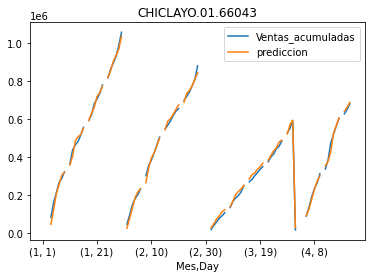

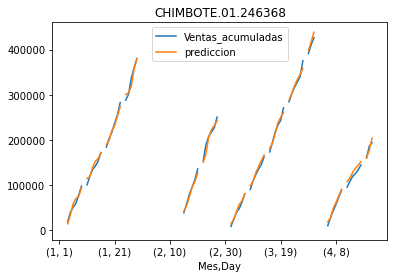

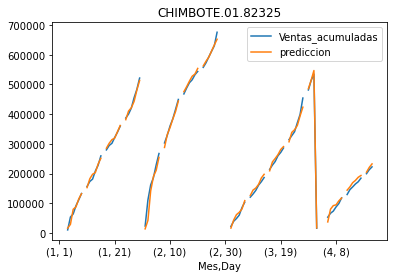

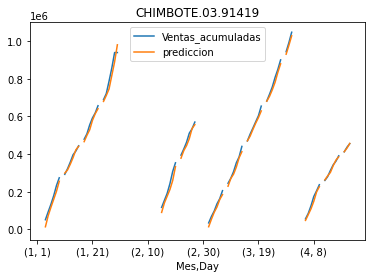

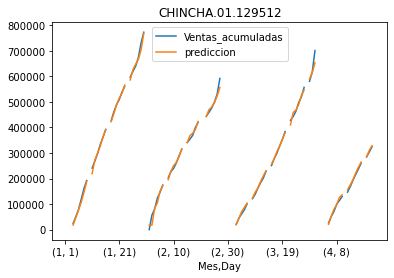

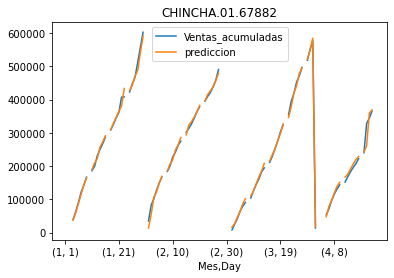

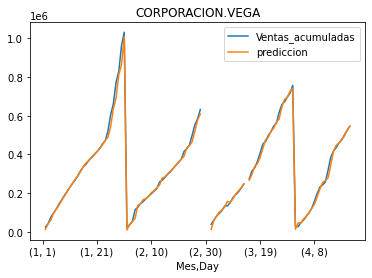

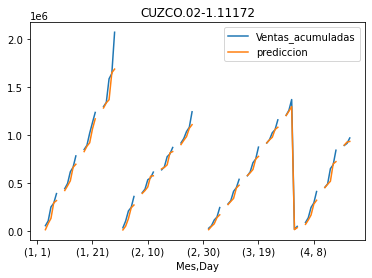

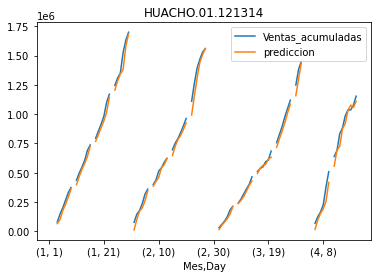

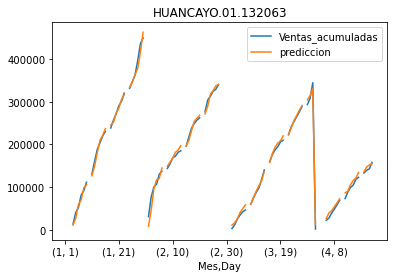

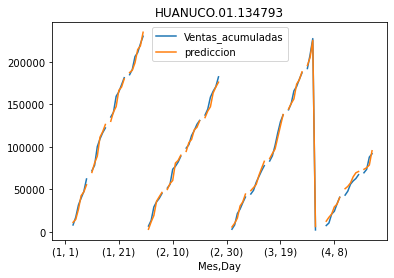

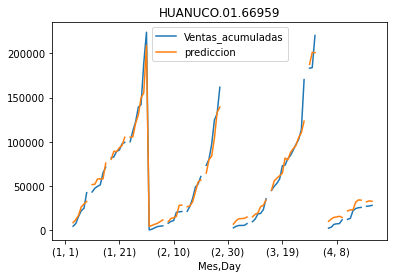

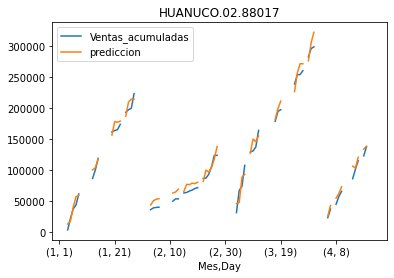

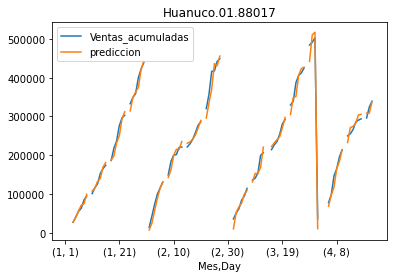

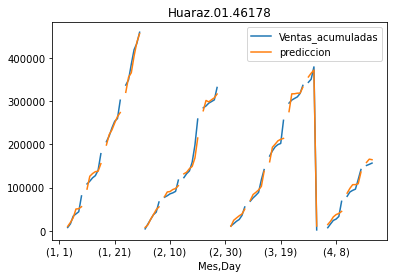

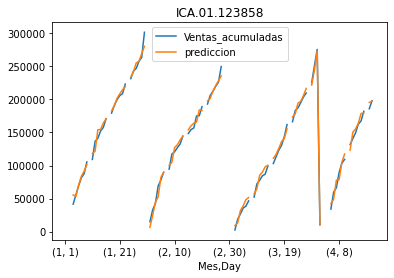

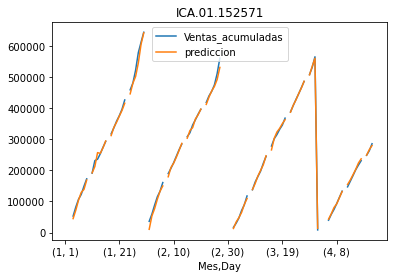

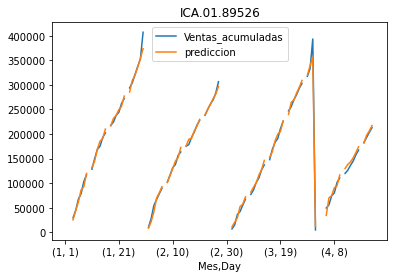

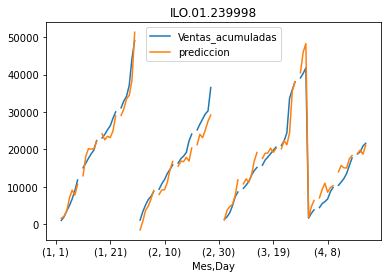

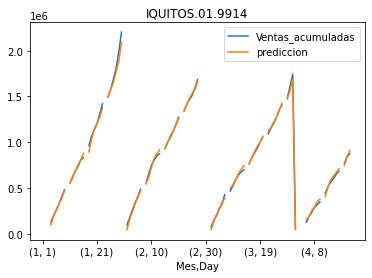

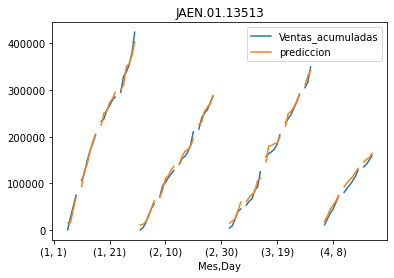

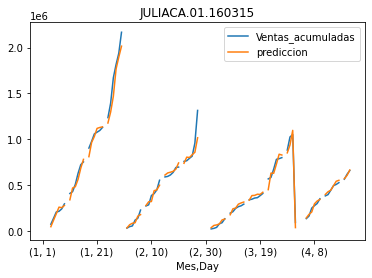

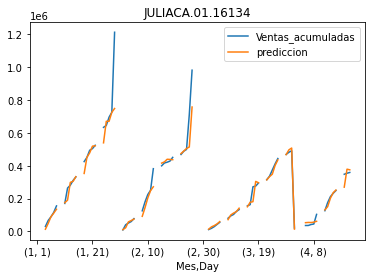

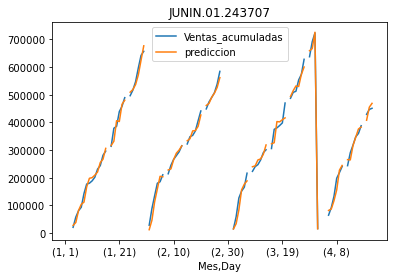

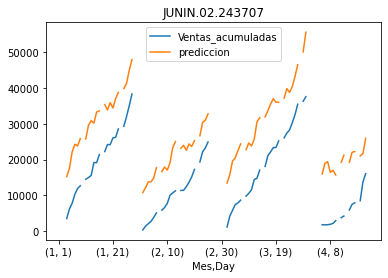

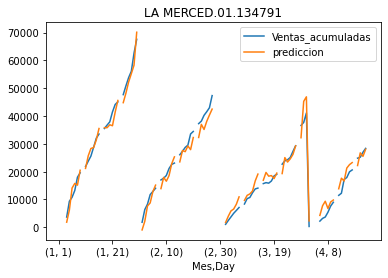

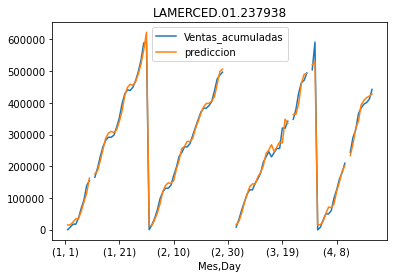

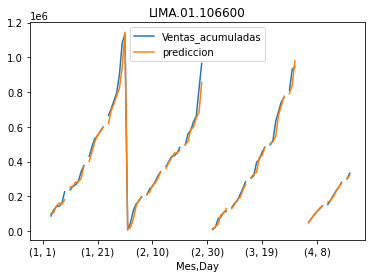

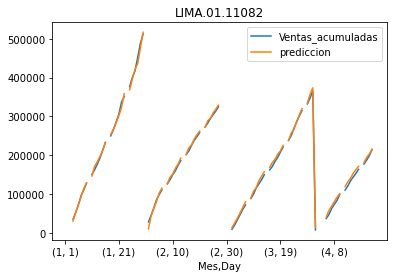

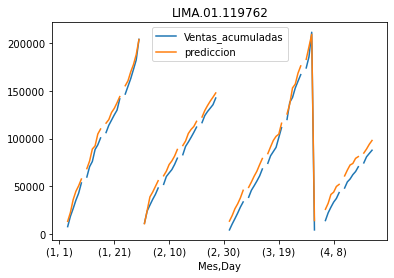

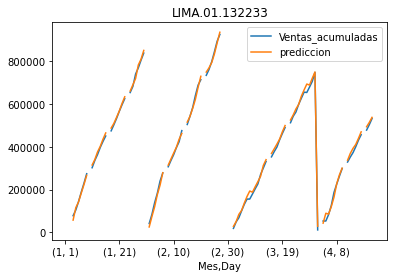

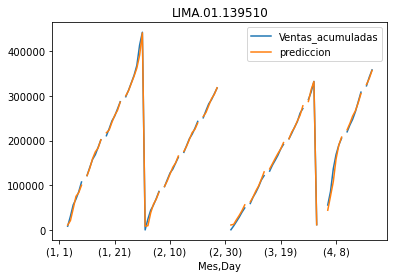

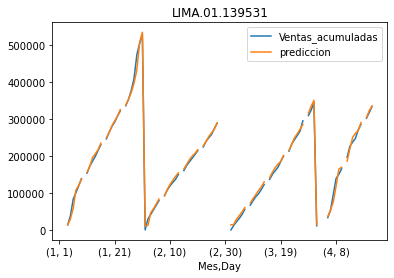

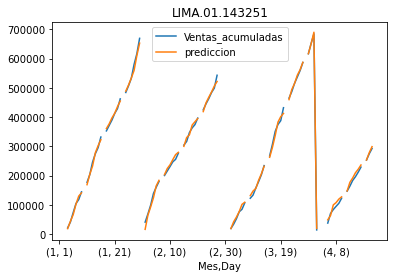

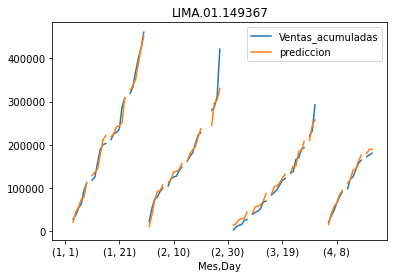

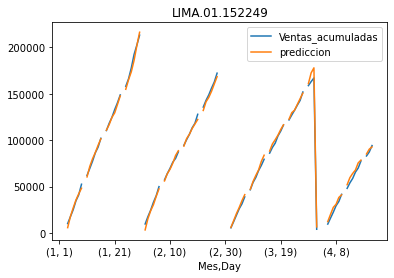

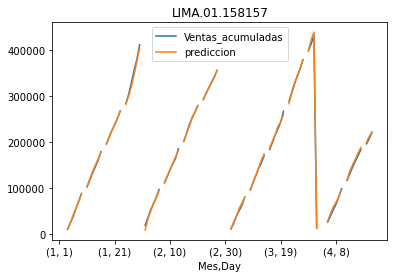

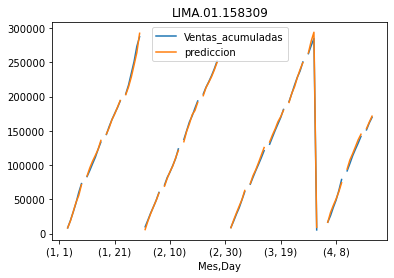

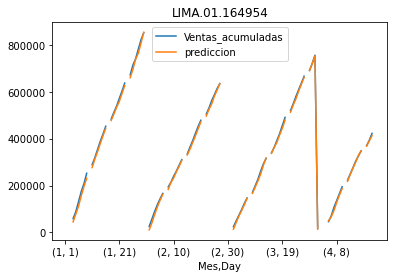

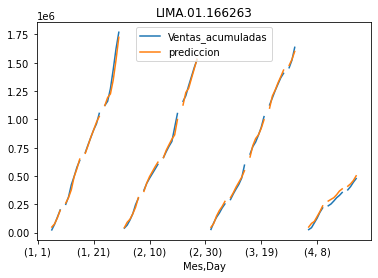

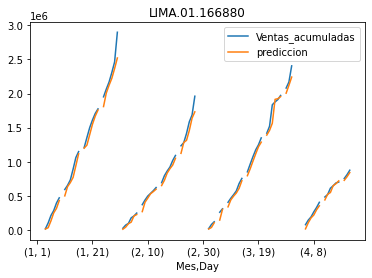

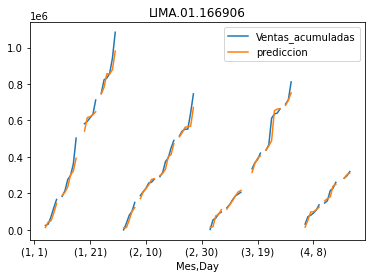

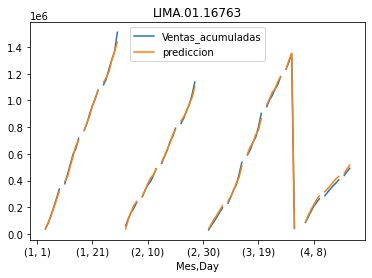

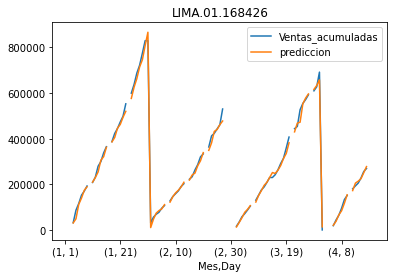

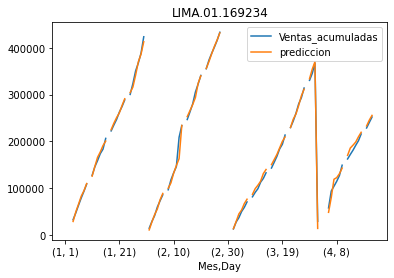

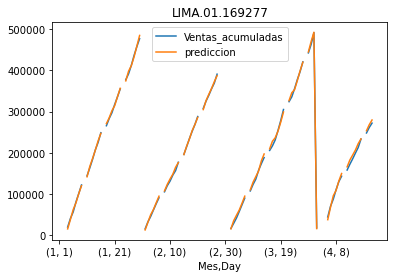

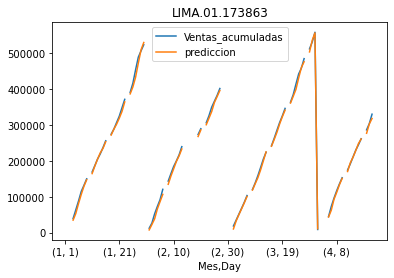

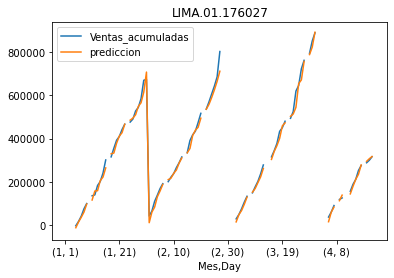

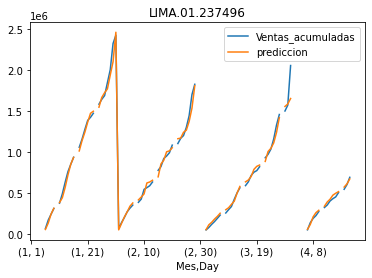

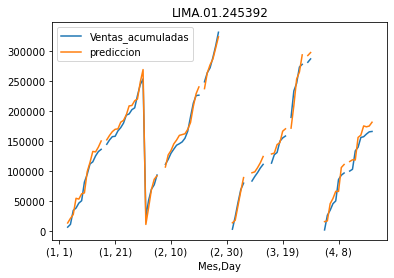

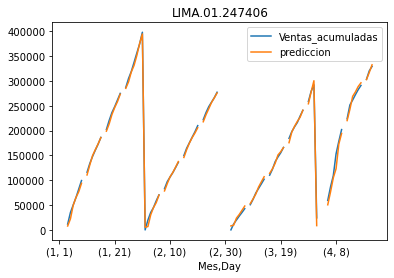

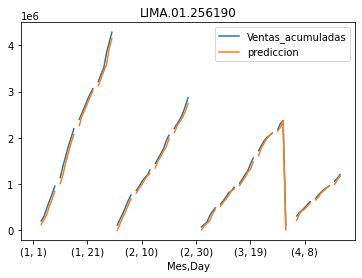

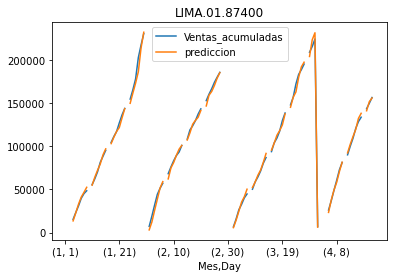

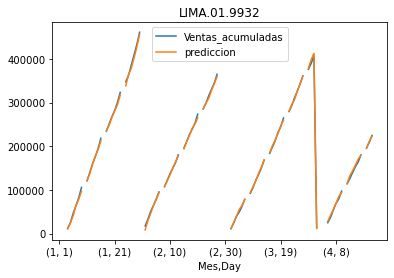

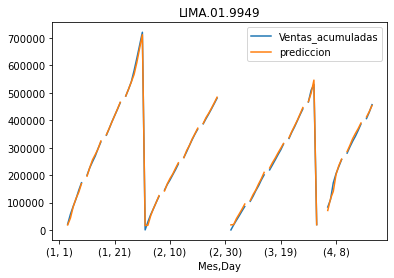

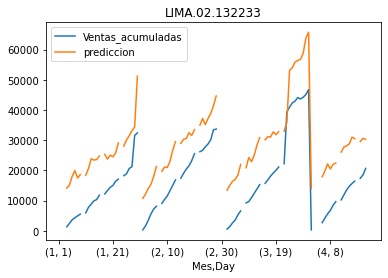

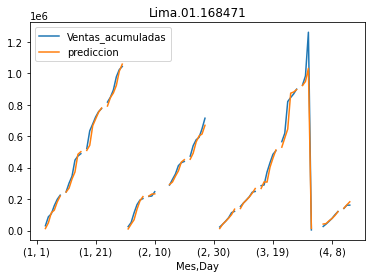

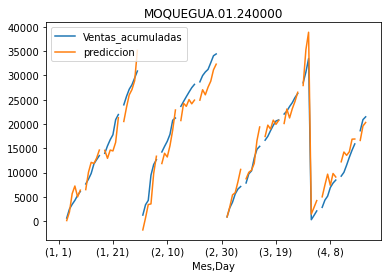

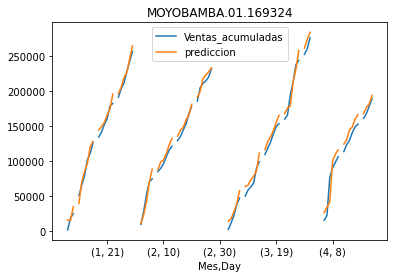

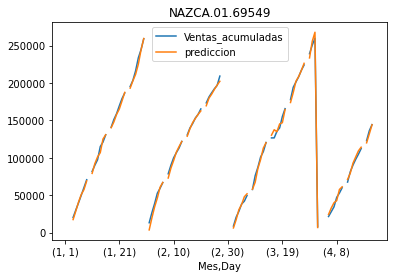

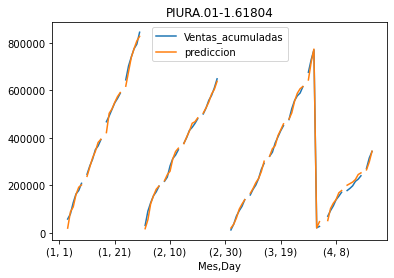

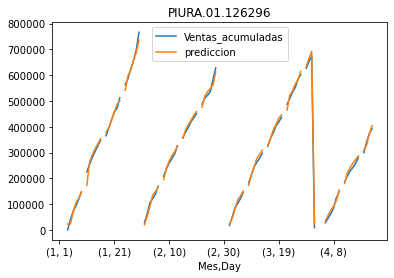

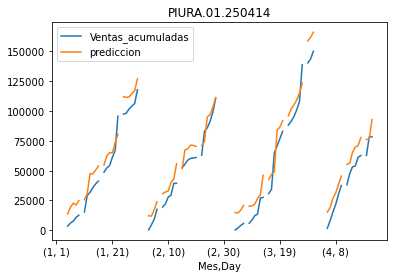

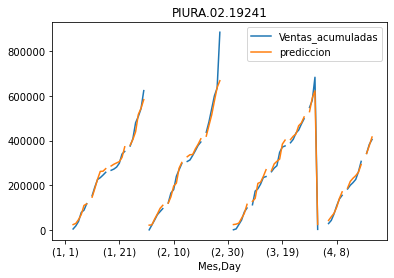

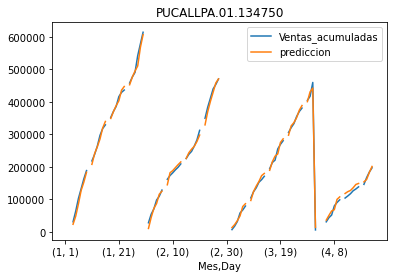

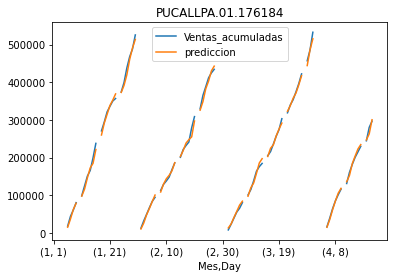

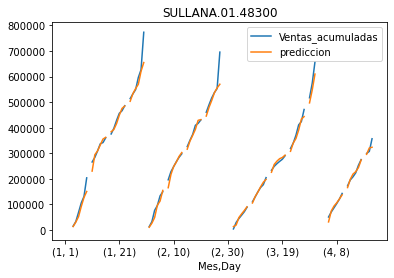

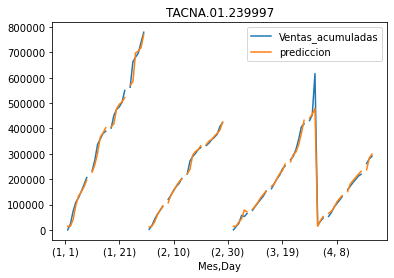

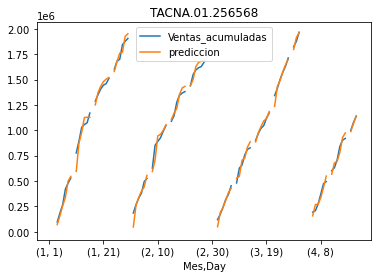

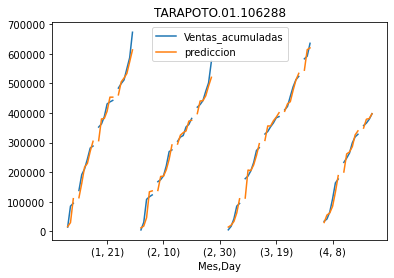

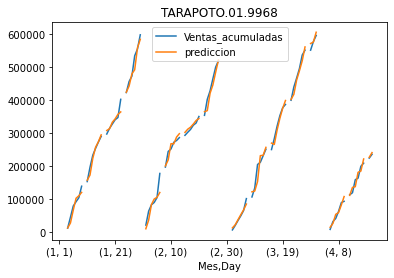

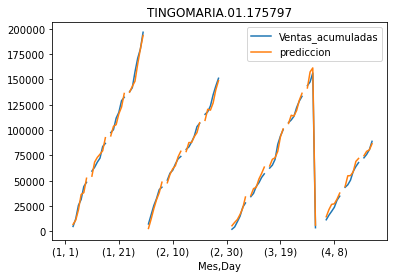

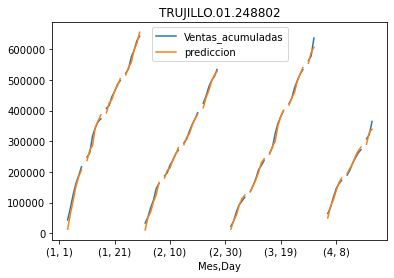

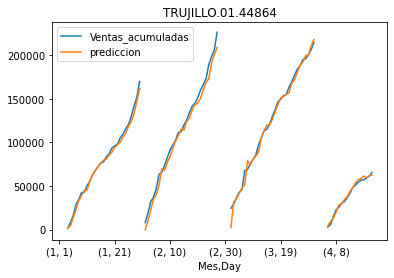

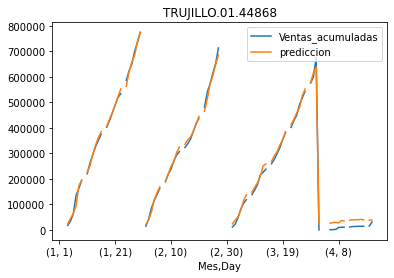

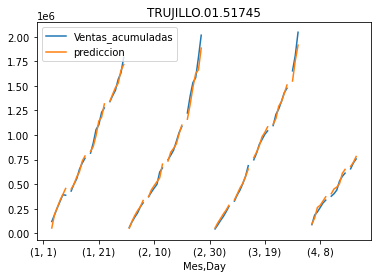

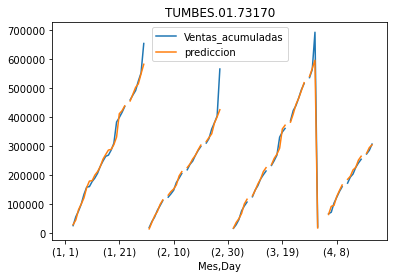

In [30]:
for i in test_data_2021.CodigoDistribuidor.unique():
    _ = test_data_2021[test_data_2021.CodigoDistribuidor == i].groupby(['Mes','Day'])[['Ventas_acumuladas','prediccion']].mean().plot()
    _ = plt.title(i)
    plt.show()

In [31]:
test_data_2021

CodigoDistribuidor Mes CodigoFecha      Ventas  Ventas_acumuladas  \
0                787878   1  2021-01-05  17166.0843         17166.0843   
1                787878   1  2021-01-06  13729.4575         30895.5418   
2                787878   1  2021-01-07  21138.0754         52033.6172   
3                787878   1  2021-01-08   9510.0923         61543.7095   
4                787878   1  2021-01-09   8576.6188         70120.3283   
...                 ...  ..         ...         ...                ...   
8734    TUMBES.01.73170   4  2021-04-16  15538.5100        241758.7200   
8735    TUMBES.01.73170   4  2021-04-17  12817.9000        254576.6200   
8736    TUMBES.01.73170   4  2021-04-19  18188.4800        272765.1000   
8737    TUMBES.01.73170   4  2021-04-20  12665.0100        285430.1100   
8738    TUMBES.01.73170   4  2021-04-21  21478.3900        306908.5000   

      Ventas_last_1  Ventas_acumuladas_last_1  Ventas_last_2  \
0            0.0000                    0.0000         0.0000   
1        17166.0843                17166.0843         0.0000   
2        13729.4575                30895.5418     17166.0843   
3        21138.0754                52033.6172     13729.4575   
4         9510.0923                61543.7095     21138.0754   
...             ...                       ...            ...   
8734     22743.5300               226220.2100     10797.6200   
8735     15538.5100               241758.7200     22743.5300   
8736     12817.9000               254576.6200     15538.5100   
8737     18188.4800               272765.1000     12817.9000   
8738     12665.0100               285430.1100     18188.4800   

      Ventas_acumuladas_last_2  Ventas_last_3  ...  Ventas_last_4  \
0                       0.0000         0.0000  ...         0.0000   
1                       0.0000         0.0000  ...         0.0000   
2                   17166.0843         0.0000  ...         0.0000   
3                   30895.5418     17166.0843  ...         0.0000   
4                   52033.6172     13729.4575  ...     17166.0843   
...                        ...            ...  ...            ...   
8734               203476.6800     20712.6500  ...     12458.8800   
8735               226220.2100     10797.6200  ...     20712.6500   
8736               241758.7200     22743.5300  ...     10797.6200   
8737               254576.6200     15538.5100  ...     22743.5300   
8738               272765.1000     12817.9000  ...     15538.5100   

      Ventas_acumuladas_last_4  Ventas_last_5  Ventas_acumuladas_last_5  \
0                       0.0000           0.00                      0.00   
1                       0.0000           0.00                      0.00   
2                       0.0000           0.00                      0.00   
3                       0.0000           0.00                      0.00   
4                   17166.0843           0.00                      0.00   
...                        ...            ...                       ...   
8734               171966.4100       16683.37                 159507.53   
8735               192679.0600       12458.88                 171966.41   
8736               203476.6800       20712.65                 192679.06   
8737               226220.2100       10797.62                 203476.68   
8738               241758.7200       22743.53                 226220.21   

      Ventas_last_6  Ventas_acumuladas_last_6  Ventas_last_7  \
0              0.00                      0.00           0.00   
1              0.00                      0.00           0.00   
2              0.00                      0.00           0.00   
3              0.00                      0.00           0.00   
4              0.00                      0.00           0.00   
...             ...                       ...            ...   
8734       20013.03                 142824.16       19863.20   
8735       16683.37                 159507.53       20013.03   
8736       12458.88                 17196

In [55]:
test_data_2021['prediccion_ventas'] = test_data_2021['prediccion'] - test_data_2021['Ventas_acumuladas_last_1'] 
print(test_data_2021.head())
test_data_2021.to_csv('data_2021.csv')

  CodigoDistribuidor Mes CodigoFecha      Ventas  Ventas_acumuladas  \
0             787878   1  2021-01-05  17166.0843         17166.0843   
1             787878   1  2021-01-06  13729.4575         30895.5418   
2             787878   1  2021-01-07  21138.0754         52033.6172   
3             787878   1  2021-01-08   9510.0923         61543.7095   
4             787878   1  2021-01-09   8576.6188         70120.3283   

   Ventas_last_1  Ventas_acumuladas_last_1  Ventas_last_2  \
0         0.0000                    0.0000         0.0000   
1     17166.0843                17166.0843         0.0000   
2     13729.4575                30895.5418     17166.0843   
3     21138.0754                52033.6172     13729.4575   
4      9510.0923                61543.7095     21138.0754   

   Ventas_acumuladas_last_2  Ventas_last_3  ...  Ventas_acumuladas_last_4  \
0                    0.0000         0.0000  ...                    0.0000   
1                    0.0000         0.0000  ...     

In [48]:
test_data_2021['prediccion_ventas'] = test_data_2021['prediccion'] - test_data_2021['Ventas_acumuladas_last_1'] 

<AxesSubplot:>

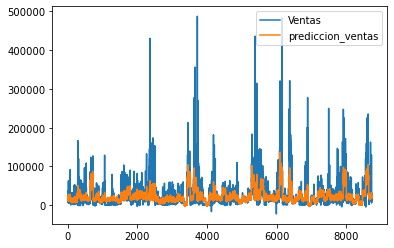

In [54]:
test_data_2021[['Ventas','prediccion_ventas']].plot()

In [33]:
test_data_2021.columns

Index(['CodigoDistribuidor', 'Mes', 'CodigoFecha', 'Ventas',
       'Ventas_acumuladas', 'Ventas_last_1', 'Ventas_acumuladas_last_1',
       'Ventas_last_2', 'Ventas_acumuladas_last_2', 'Ventas_last_3',
       'Ventas_acumuladas_last_3', 'Ventas_last_4', 'Ventas_acumuladas_last_4',
       'Ventas_last_5', 'Ventas_acumuladas_last_5', 'Ventas_last_6',
       'Ventas_acumuladas_last_6', 'Ventas_last_7', 'Ventas_acumuladas_last_7',
       'Day', 'prediccion'],
      dtype='object')

In [34]:
from datetime import date

today = date.today()

columns=['CodigoDistribuidor', 'Mes', 'CodigoFecha', 'Ventas','Ventas_acumuladas', 'Ventas_last_1', 'Ventas_acumuladas_last_1',
                                       'Ventas_last_2', 'Ventas_acumuladas_last_2', 'Ventas_last_3',
                                        'Ventas_acumuladas_last_3', 'Ventas_last_4', 'Ventas_acumuladas_last_4',
                                        'Ventas_last_5', 'Ventas_acumuladas_last_5', 'Ventas_last_6',
                                        'Ventas_acumuladas_last_6', 'Ventas_last_7', 'Ventas_acumuladas_last_7', 'Day']

data_today = pd.DataFrame(columns=columns)
data_today.CodigoDistribuidor = test_data_2021.CodigoDistribuidor.unique()
data_today.CodigoFecha = pd.to_datetime(today)
data_today.Mes = data_today.CodigoFecha.dt.month
data_today.Day = data_today.CodigoFecha.dt.day
data_copy = data_today.copy()
for i in test_data_2021.CodigoDistribuidor.unique():    
       
    print(test_data_2021[test_data_2021.CodigoDistribuidor == i].sort_values(by='CodigoFecha').iloc[-1])    

CodigoDistribuidor                       787878
Mes                                           4
CodigoFecha                 2021-04-21 00:00:00
Ventas                               13600.7272
Ventas_acumuladas                   173286.2998
Ventas_last_1                        22872.4659
Ventas_acumuladas_last_1            159685.5726
Ventas_last_2                         8377.3978
Ventas_acumuladas_last_2            136813.1067
Ventas_last_3                         8100.0334
Ventas_acumuladas_last_3            128435.7089
Ventas_last_4                        11640.2204
Ventas_acumuladas_last_4            120335.6755
Ventas_last_5                         10969.406
Ventas_acumuladas_last_5            108695.4551
Ventas_last_6                         8632.2284
Ventas_acumuladas_last_6             97726.0491
Ventas_last_7                        14759.9151
Ventas_acumuladas_last_7             89093.8207
Day                                          21
prediccion                        175590

CodigoDistribuidor               PIURA.02.19241
Mes                                           4
CodigoFecha                 2021-04-21 00:00:00
Ventas                                  22017.9
Ventas_acumuladas                     405018.51
Ventas_last_1                          40220.25
Ventas_acumuladas_last_1              383000.61
Ventas_last_2                          35827.76
Ventas_acumuladas_last_2              342780.36
Ventas_last_3                          46587.02
Ventas_acumuladas_last_3               306952.6
Ventas_last_4                          34194.51
Ventas_acumuladas_last_4              260365.58
Ventas_last_5                          14297.45
Ventas_acumuladas_last_5              226171.07
Ventas_last_6                          11808.73
Ventas_acumuladas_last_6              211873.62
Ventas_last_7                          16661.74
Ventas_acumuladas_last_7              200064.89
Day                                          21
prediccion                        416108

In [35]:
data_today = test_data_2021[test_data_2021['CodigoFecha']=='2021-04-21']

In [36]:
from datetime import date

today = date.today()

data_today.CodigoFecha = pd.to_datetime(today)

C:\Users\DELL\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [37]:
data_today.drop('prediccion',axis=1,inplace=True)

C:\Users\DELL\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [38]:
data_today.Day = data_today.CodigoFecha.dt.day

In [39]:
data_today['Ventas_last_7'] = data_today['Ventas_last_6']
data_today['Ventas_last_6'] = data_today['Ventas_last_5']
data_today['Ventas_last_5'] = data_today['Ventas_last_4']
data_today['Ventas_last_4'] = data_today['Ventas_last_3']
data_today['Ventas_last_3'] = data_today['Ventas_last_2']
data_today['Ventas_last_2'] = data_today['Ventas_last_1']
data_today['Ventas_last_1'] = data_today['Ventas']

data_today['Ventas_acumuladas_last_7'] = data_today['Ventas_acumuladas_last_6']
data_today['Ventas_acumuladas_6'] = data_today['Ventas_acumuladas_last_5']
data_today['Ventas_acumuladas_5'] = data_today['Ventas_acumuladas_last_4']
data_today['Ventas_acumuladas_last_4'] = data_today['Ventas_acumuladas_last_3']
data_today['Ventas_acumuladas_last_3'] = data_today['Ventas_acumuladas_last_2']
data_today['Ventas_acumuladas_last_2'] = data_today['Ventas_acumuladas_last_1']
data_today['Ventas_acumuladas_last_1'] = data_today['Ventas_acumuladas']

<ipython-input-39-9f1eecc09250>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_today['Ventas_last_7'] = data_today['Ventas_last_6']
<ipython-input-39-9f1eecc09250>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_today['Ventas_last_6'] = data_today['Ventas_last_5']
<ipython-input-39-9f1eecc09250>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [40]:
data_today.drop(['Ventas','Ventas_acumuladas','CodigoFecha'],axis=1,inplace=True)

In [41]:
data_today.drop(['Ventas_acumuladas_6','Ventas_acumuladas_5'],axis=1,inplace=True)

In [42]:
data_today['prediccion'] = gm_cv.predict(data_today)

<ipython-input-42-19ad6499b9c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_today['prediccion'] = gm_cv.predict(data_today)


In [43]:
data_today.to_csv('data_today.csv')

<AxesSubplot:>

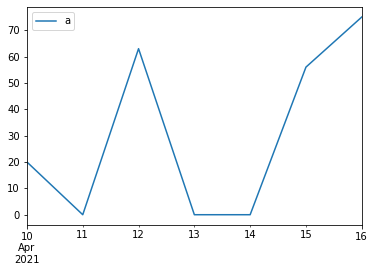

In [57]:
import pandas as pd
data = pd.DataFrame({'a':[20,63,56,75],'date':['2021-04-10','2021-04-12','2021-04-15','2021-04-16']})
data.date = pd.to_datetime(data.date)
fechas = pd.date_range(data.date.min(), data.date.max(),freq='D')
data = data.set_index('date').reindex(fechas).fillna(0.00)
data.plot()